# **BEAT THE BOOKIE**

**Group Name:** *Team B*

**Group Members:** *Youngwoo Jung, Jason Kim, Harryn Oh, Dongyeon Park, Luis Rodrigues Vieira, Haoyi Zhang*

## **Contents**

- [**1. Introduction**](#introduction)

- [**2. Data Import**](#import)
- [**3. Data Transformation & Exploration**](#transformation_exploration)
  - [**3.1. Data Preprocessing**](#preprocessing)
  - [**3.2. Raw Features Replacement**](#replacement)
  - [**3.3. Feature Encoding**](#encoding)
  - [**3.3. Feature Selection**](#selection)
    - [**3.3.1. Wrapper Method**](#wrapper)
    - [**3.3.2. Fillter Method**](#filter)
      - [**3.3.2.1. Pearson Correlation (Univariate Filter)**](#univariate_filter)
      - [**3.3.2.2. Removing Correlated Features (Multivariate Filter)**](#multivariate_filter)
    - [**3.3.3. Embedded Method**](#embedded)
      - [**3.3.3.1. Elastic Net**](#elastic)
      - [**3.3.3.2. Random Forest**](#random_forest)

- [**4. Methodology Overview**](#methodology_overview)
- [**5. Model Training & Validation**](#training_validation)
- [**6. Results**](#results)
- [**7. Final Predictions on Test Set**](#final_predictions)

<a name='introduction'><a/>
# 1. Introduction

Machine learning is an important technique that underpins the rapid development of the modern world. In thie present, 68\% of large companies, 33\% of medium-sized companies, and 15\% of small companies in the UK have incorporated at least one AI technology[1]. Classification is one of the most classic topics in machine learning, which can be traced back to late 1950s and early 1960s and still widely used today[2]. It is a supervised machine learning process of categorizing a given set of input data into classes based on one or more variables. In this project, we aim to predict the outcomes of English Premier League (EPL) football matches by leveraging machine learning algorithms trained on historical results data. This contains several steps to come out with a prediction including Data Transformation \& Exploration, Model Training \& Validation etc.. We have explored a variety of classification algorithms such as Support Vector Machines (SVM), logistic Regression, RandomForest and GradientBoosting to find out what is the most appropriate algorithm to predict. Our findings indicate that, with the processed data, we achieved a best validation accuracy of about 54\%. This suggests that our models can predict EPL match outcomes with a reasonable degree of accuracy, providing valuable insights into the dynamics of football match results.

<a name='import'><a/>
# 2. Data Import

In [1258]:
!pip install optuna

In [1259]:
# Library Imports
import os
import re
import time
import warnings
from itertools import zip_longest

import numpy as np
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import (GradientBoostingClassifier,
                             HistGradientBoostingClassifier,
                             RandomForestClassifier)
from sklearn.feature_selection import RFE
from sklearn.linear_model import (ElasticNet, LogisticRegression,
                                  RidgeClassifierCV)
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import (RandomizedSearchCV, train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")
%matplotlib inline

If we want to share data, Harryn needs to grant access to the Google Drive.   
Or You can run the code to mount your drive in Colab using your Google Drive, or alternatively, you can run it locally.

In [1260]:
drive_mount = False # if you want to run locally it should be False

In [1261]:
if drive_mount:
  from google.colab import drive

In [1262]:
if drive_mount:
  # set this path to your appropriate drive path
  dataset_path = '/content/COMP0036/'
else:
  # In this case, the datasets path is assumed to be in the same directory as this notebook
  dataset_path = "./"

assert(os.path.exists(dataset_path))

In [1263]:
# Import the epl-training(original) data
original_df = pd.read_csv(dataset_path + 'epl-training.csv')

In [1264]:
# Crawling code once we did we don't need to do more
'''
years = list(range(2023,2017,-1))
all_matches = []

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
    'Cookie': '__Secure-3PSID=dQjjULtfI_l2MCvoFUHFgsW3kb_G7qHXkqpAKBXG1tEgGIaYEWvfJnmOCBdNLxofL5vDlA.; __Secure-3PAPISID=eSd5DV2F9CXSjmdH/A1rgLdtTsUCThGowU; __Secure-3PSIDTS=sidts-CjIBNiGH7ikV9KPC487BaxNOtdzOphwn68ORKCM1hN48AFSbUbz8zSqdQKbxd-e5ReKOBxAA; NID=511=qd1w6PTzoTUYpPNp3wll48P9D7knEl-DtKnykrPqC3-N2xpK6L_uor09WTFyStspacB6pBtgX6chv3Wdk9abpl6UmIqP_QxD1ZDp1lmTfktOubRpnaxyoI8rc6l7otkLVfW_gVxX1EOm5O7-LZKTUR1G151YuesuhukuOA3S-6cH69slfXkmgu5IGHby_gevKXRyE3xBi3kWhFfyGDeTxoDvzYq8DaVa5QoLEtAmRCmt377XMYUvHsKXwHLlxoVr_NXbvxoz7yDny9YGG_IbCtPNkvjQOX5krdKOIhxiWGQzRAHWCZcaMvA; __Secure-3PSIDCC=ACA-OxO49OvaP1CoAmlCoWotjCuzVE3ryVD-kIj71hOpHCKhVPJHVA9EcEUyFRB4HO6IIN6CHw'

}
url = "https://fbref.com/en/comps/9/Premier-Leaue-Stats"

for year in years:
    data = requests.get(url, headers=headers)
    soup = BeautifulSoup(data.text)
    table = soup.select('table.stats_table')[0]
    links = [anchor.get("href") for anchor in table.find_all('a')]
    squad_links = [link for link in links if '/squads/' in link]
    full_urls = [f"https://fbref.com{link}" for link in squad_links]

    previous_season = soup.select("a.prev")[0].get("href")
    url = f"https://fbref.com/{previous_season}"

    for full_url in full_urls:
        squad_name = full_url.split("/")[-1].replace("-Stats","").replace("-"," ")

        data = requests.get(full_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]

        soup = BeautifulSoup(data.text)
        links = [anchor.get("href") for anchor in soup.find_all('a')]
        shooting_links = [link for link in links if link and 'all_comps/shooting/' in link]
        data = requests.get(f"https://fbref.com{shooting_links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()

        try:
          team_data = matches.merge(shooting[["Date","Sh","SoT", "Dist","FK","PK","PKatt","npxG"]], on="Date")
        except ValueError:
          continue

        team_data = team_data[team_data["Comp"] == "Premier League"]
        team_data["Season"] = year
        team_data["Team"] = squad_name
        all_matches.append(team_data)

        time.sleep(5)

match_df = pd.concat(all_matches)
match_df.columns = [c.lower() for c in match_df.columns]
match_df.to_csv("matches.csv")
'''


'\nyears = list(range(2023,2017,-1))\nall_matches = []\n\nheaders = {\n    \'User-Agent\': \'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36\',\n    \'Cookie\': \'__Secure-3PSID=dQjjULtfI_l2MCvoFUHFgsW3kb_G7qHXkqpAKBXG1tEgGIaYEWvfJnmOCBdNLxofL5vDlA.; __Secure-3PAPISID=eSd5DV2F9CXSjmdH/A1rgLdtTsUCThGowU; __Secure-3PSIDTS=sidts-CjIBNiGH7ikV9KPC487BaxNOtdzOphwn68ORKCM1hN48AFSbUbz8zSqdQKbxd-e5ReKOBxAA; NID=511=qd1w6PTzoTUYpPNp3wll48P9D7knEl-DtKnykrPqC3-N2xpK6L_uor09WTFyStspacB6pBtgX6chv3Wdk9abpl6UmIqP_QxD1ZDp1lmTfktOubRpnaxyoI8rc6l7otkLVfW_gVxX1EOm5O7-LZKTUR1G151YuesuhukuOA3S-6cH69slfXkmgu5IGHby_gevKXRyE3xBi3kWhFfyGDeTxoDvzYq8DaVa5QoLEtAmRCmt377XMYUvHsKXwHLlxoVr_NXbvxoz7yDny9YGG_IbCtPNkvjQOX5krdKOIhxiWGQzRAHWCZcaMvA; __Secure-3PSIDCC=ACA-OxO49OvaP1CoAmlCoWotjCuzVE3ryVD-kIj71hOpHCKhVPJHVA9EcEUyFRB4HO6IIN6CHw\'\n\n}\nurl = "https://fbref.com/en/comps/9/Premier-Leaue-Stats"\n\nfor year in years:\n    data = requests.get(url

In [1265]:
# Import the crawled(cralwling) data for extras
crawling_df = pd.read_csv(dataset_path + 'matches.csv', index_col=0)

In [1266]:
# Import the test data
test_df = pd.read_csv(dataset_path + 'epl-test.csv')

<a name='transformation_exploration'><a/>
# 3. Data Transformation & Exploration

<a name='preprocessing'></a>
## 3.1. Data Preprocessing

In [1267]:
# View the original data and it's corresponding data types.
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8841 entries, 0 to 8840
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      8840 non-null   object 
 1   HomeTeam  8840 non-null   object 
 2   AwayTeam  8840 non-null   object 
 3   FTHG      8840 non-null   float64
 4   FTAG      8840 non-null   float64
 5   FTR       8840 non-null   object 
 6   HTHG      8840 non-null   float64
 7   HTAG      8840 non-null   float64
 8   HTR       8840 non-null   object 
 9   Referee   8840 non-null   object 
 10  HS        8840 non-null   float64
 11  AS        8840 non-null   float64
 12  HST       8840 non-null   float64
 13  AST       8840 non-null   float64
 14  HC        8840 non-null   float64
 15  AC        8840 non-null   float64
 16  HF        8840 non-null   float64
 17  AF        8840 non-null   float64
 18  HY        8840 non-null   float64
 19  AY        8840 non-null   float64
 20  HR        8840 non-null   floa

In [1268]:
# Check whether all original dates have the same format
original_date_lengths = original_df.Date.str.len()
original_date_lengths.value_counts()

Date
8.0     5700
10.0    3140
Name: count, dtype: int64

In [1269]:
# Check what formats they are using
condition1 = (original_date_lengths == 8)
condition2 = (original_date_lengths == 10)
print(original_df.loc[condition1, "Date"].head(1))
print(original_df.loc[condition2, "Date"].head(1))

0    19/08/00
Name: Date, dtype: object
760    17/08/2002
Name: Date, dtype: object


In [1270]:
# Specify date formats
date_formats = ['%d/%m/%y', '%d/%m/%Y']

# Standardize the format of the date column.
def convert_date(date_str):
    for fmt in date_formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return 'InvalidDate'

original_df['Date'] = original_df['Date'].apply(convert_date)

In [1271]:
# Drop invalid dates and reset the index
original_df = original_df[original_df['Date'] != 'InvalidDate']
original_df = original_df.reset_index(drop=True)

# Sort the rows by Dates and Referee Name
original_df.sort_values(by=['Date', 'Referee'], inplace=True)

# Filter rows based on the specified date
# We will use last 5 years data
# where 9/7/2018 is the start of the season
date_threshold = pd.to_datetime('9/7/2018', format='%d/%m/%Y')
original_df = original_df[original_df['Date'] >= date_threshold]

In [1272]:
# View the crawling data and its corresponding data types.
crawling_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4060 entries, 1 to 39
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          4060 non-null   object 
 1   time          4060 non-null   object 
 2   comp          4060 non-null   object 
 3   round         4060 non-null   object 
 4   day           4060 non-null   object 
 5   venue         4060 non-null   object 
 6   result        4060 non-null   object 
 7   gf            4060 non-null   float64
 8   ga            4060 non-null   float64
 9   opponent      4060 non-null   object 
 10  xg            4060 non-null   float64
 11  xga           4060 non-null   float64
 12  poss          4060 non-null   float64
 13  attendance    3176 non-null   float64
 14  captain       4060 non-null   object 
 15  formation     4060 non-null   object 
 16  referee       4060 non-null   object 
 17  match report  4060 non-null   object 
 18  notes         0 non-null      float

In [1273]:
# Check all crawling dates have the same format
crawling_date_lengths = crawling_df.date.str.len()
crawling_date_lengths.value_counts()

date
10    4060
Name: count, dtype: int64

In [1274]:
# Check what formats they are using
condition = (crawling_date_lengths == 10)
crawling_df.loc[condition, "date"].head(1)

1    2023-08-12
Name: date, dtype: object

In [1275]:
# Convert the 'date' column dtypes to datetime
crawling_df["date"] = pd.to_datetime(crawling_df["date"], format='%Y-%m-%d')

# Sort the rows based on Date and Referee
crawling_df.sort_values(by=['date', 'referee'], inplace=True)

In [1276]:
# Check which columns have valuable data
crawling_df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,notes,sh,sot,dist,fk,pk,pkatt,npxg,season,team
0,2018-08-10,20:00,Premier League,Matchweek 1,Fri,Home,W,2.0,1.0,Leicester City,...,NaN,7.0,5.0,20.8,0.0,1,1,0.7,2018,Manchester United
0,2018-08-10,20:00,Premier League,Matchweek 1,Fri,Away,L,1.0,2.0,Manchester Utd,...,NaN,13.0,4.0,20.6,1.0,0,0,1.8,2018,Leicester City
1,2018-08-11,15:00,Premier League,Matchweek 1,Sat,Away,W,3.0,0.0,Huddersfield,...,NaN,12.0,3.0,17.7,2.0,1,1,1.1,2018,Chelsea
0,2018-08-11,15:00,Premier League,Matchweek 1,Sat,Home,L,0.0,3.0,Chelsea,...,NaN,6.0,1.0,18.4,0.0,0,0,0.3,2018,Huddersfield Town
0,2018-08-11,17:30,Premier League,Matchweek 1,Sat,Home,D,2.0,2.0,Everton,...,NaN,11.0,4.0,23.1,1.0,0,0,1.0,2018,Wolverhampton Wanderers


In [1277]:
# View the test data and its corresponding data types.
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      10 non-null     object
 1   HomeTeam  10 non-null     object
 2   AwayTeam  10 non-null     object
dtypes: object(3)
memory usage: 368.0+ bytes


In [1278]:
# Check all the dates have the same format
test_date_lengths = test_df.Date.str.len()
test_date_lengths.value_counts()

Date
9    10
Name: count, dtype: int64

In [1279]:
# Check what formats the test data is using
condition = (test_date_lengths == 9)
test_df.loc[condition, "Date"].head(1)

0    03-Feb-24
Name: Date, dtype: object

In [1280]:
# Convert the 'date' column dtypes to datetime
test_df["Date"] = pd.to_datetime(test_df["Date"], format='%d-%b-%y', dayfirst=True)

In [1281]:
# Features that is not related to the result is dropped
crawling_df.drop(columns=['time', 'comp', 'round', 'day',
                 'attendance', 'captain', 'formation',
                 'match report', 'notes'], inplace=True)

# Drop other person's estimated values, so it can only use our own set of features
crawling_df.drop(columns=['sh', 'sot',
                 'xg', 'xga', 'season', 'npxg',
                 'gf', 'ga'], inplace=True)

# Drop the result since we are training based on the original data
crawling_df.drop(columns=['result'], inplace=True)

# Rename the columns to match with the original data
crawling_df = crawling_df.rename(columns={'date': 'Date', 'referee': 'Referee'})

In [1282]:
def merge_rows(df):
    # filtering based on venue
    df_away = df[df['venue'] == 'Away']
    df_home = df[df['venue'] == 'Home']

    # merge rows based on 'Date' and 'Referee'
    merged_df = pd.merge(df_away, df_home, on=['Date', 'Referee'], how='outer', suffixes=('_A', '_H'))

    return merged_df

# Same 'Date' and 'Referee' is considered the same match
# Merge HomeTeam, AwayTeam stats based on 'Date' and 'Referee'
crawling_df = merge_rows(crawling_df)

In [1283]:
def cleanUpData(df):
    # Drop venue column since it is no longer needed
    # Drop team_A and opponent_A since this is based on AwayTeam
    df.drop(columns=['venue_A',  'venue_H', 'team_A', 'opponent_A',], inplace=True)

    # Rename team_H as HomeTeam and opponent_H to AwayTeam
    df = df.rename(columns={'team_H': 'HomeTeam', 'opponent_H': 'AwayTeam'})

    return df

# Drop and rename columns to match with the original data
crawling_df = cleanUpData(crawling_df)

In [1284]:
# Rearrage the columns
crawling_df = crawling_df[['Date', 'HomeTeam', 'AwayTeam', 'poss_H',
                           'dist_H', 'fk_H', 'pk_H', 'pkatt_H', 'poss_A',
                           'dist_A', 'fk_A', 'pk_A', 'pkatt_A', 'Referee']]

In [1285]:
print("Original Shape:", original_df.shape)
print("Crawling Shape:", crawling_df.shape)

Original Shape: (2000, 22)
Crawling Shape: (2030, 14)


In [1286]:
# Check any missing values
print("Original Data")
print(original_df.isna().sum())
print("Crawling Data")
print(crawling_df.isna().sum())

Original Data
Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
Referee     0
HS          0
AS          0
HST         0
AST         0
HC          0
AC          0
HF          0
AF          0
HY          0
AY          0
HR          0
AR          0
dtype: int64
Crawling Data
Date        0
HomeTeam    0
AwayTeam    0
poss_H      0
dist_H      2
fk_H        0
pk_H        0
pkatt_H     0
poss_A      0
dist_A      0
fk_A        0
pk_A        0
pkatt_A     0
Referee     0
dtype: int64


In [1287]:
# Check if it's reasonable to drop the rows with missing vaulue
any_null_rows = crawling_df[crawling_df.isnull().any(axis=1)]
print(any_null_rows)

          Date        HomeTeam         AwayTeam  poss_H  dist_H  fk_H  pk_H  \
282 2019-03-02     Bournemouth  Manchester City    19.0     NaN   0.0     0   
805 2020-10-18  Crystal Palace         Brighton    34.0     NaN   0.0     1   

     pkatt_H  poss_A  dist_A  fk_A  pk_A  pkatt_A         Referee  
282        0    81.0    17.9   0.0     0        0    Kevin Friend  
805        1    66.0    16.0   0.0     0        0  Stuart Attwell  


In [1288]:
# Remove any missing values and reset the index
original_df.dropna(inplace=True)
original_df = original_df.reset_index(drop=True)

crawling_df.dropna(inplace=True)
crawling_df = crawling_df.reset_index(drop=True)

print(original_df.shape)
print(crawling_df.shape)

(2000, 22)
(2028, 14)


In [1289]:
# Before we merge two csv files,
# we need to make 'Date' and 'Referee' be the same data frames
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2000 non-null   datetime64[ns]
 1   HomeTeam  2000 non-null   object        
 2   AwayTeam  2000 non-null   object        
 3   FTHG      2000 non-null   float64       
 4   FTAG      2000 non-null   float64       
 5   FTR       2000 non-null   object        
 6   HTHG      2000 non-null   float64       
 7   HTAG      2000 non-null   float64       
 8   HTR       2000 non-null   object        
 9   Referee   2000 non-null   object        
 10  HS        2000 non-null   float64       
 11  AS        2000 non-null   float64       
 12  HST       2000 non-null   float64       
 13  AST       2000 non-null   float64       
 14  HC        2000 non-null   float64       
 15  AC        2000 non-null   float64       
 16  HF        2000 non-null   float64       
 17  AF        2000

In [1290]:
# Original data
print(original_df['HomeTeam'].unique())
print(*(original_df['Referee'].unique()), sep='\n')

['Man United' 'Huddersfield' 'Wolves' 'Watford' 'Bournemouth' 'Newcastle'
 'Fulham' 'Liverpool' 'Southampton' 'Arsenal' 'Tottenham' 'Cardiff'
 'Everton' 'Chelsea' 'Leicester' 'West Ham' 'Man City' 'Brighton'
 'Burnley' 'Crystal Palace' 'Aston Villa' 'Norwich' 'Sheffield United'
 'West Brom' 'Leeds' 'Brentford' "Nott'm Forest" 'Luton']
A Marriner
C Kavanagh
C Pawson
J Moss
K Friend
M Atkinson
M Dean
A Taylor
G Scott
M Oliver
L Mason
S Attwell
P Tierney
L Probert
D Coote
R East
S Hooper
A Madley
O Langford
P Bankes
T Robinson
R Jones
D England
S Scott
A Moss
J Gillett
M Salisbury
J Brooks
T Harrington
T Bramall
R Madley
D Bond
J Smith
S Barrott
C Salisbury


In [1291]:
# Crawling data
print(crawling_df['HomeTeam'].unique())
print(*(crawling_df['Referee'].unique()), sep='\n')

['Manchester United' 'Huddersfield Town' 'Wolverhampton Wanderers'
 'Watford' 'Bournemouth' 'Newcastle United' 'Fulham' 'Liverpool'
 'Southampton' 'Arsenal' 'Tottenham Hotspur' 'Cardiff City' 'Everton'
 'Chelsea' 'Leicester City' 'West Ham United' 'Manchester City'
 'Brighton and Hove Albion' 'Burnley' 'Crystal Palace' 'Aston Villa'
 'Norwich City' 'Sheffield United' 'West Bromwich Albion' 'Leeds United'
 'Brentford' 'Nottingham Forest' 'Luton Town']
Andre Marriner
Chris Kavanagh
Craig Pawson
Jonathan Moss
Kevin Friend
Martin Atkinson
Mike Dean
Anthony Taylor
Graham Scott
Michael Oliver
Lee Mason
Stuart Attwell
Paul Tierney
Lee Probert
David Coote
Roger East
Simon Hooper
Andy Madley
Oliver Langford
Peter Bankes
Tim Robinson
Robert Jones
Darren England
Jarred Gillett
Michael Salisbury
John Brooks
Tony Harrington
Thomas Bramall
Robert Madley
Darren Bond
Joshua Smith
Samuel Barrott


In [1292]:
# Create a dictionary to match the team name as the original data
team_name_mapping = {
    'AFC Bournemouth': 'Bournemouth',
    'Man Utd': 'Man United',
    'Sheff Utd': 'Sheffield United',
    'Nottingham Forest': "Nott'm Forest",
    'Spurs': 'Tottenham',
    'Luton Town': 'Luton'
}

# Replace the test name with the dictionary
test_df['HomeTeam'].replace(team_name_mapping, inplace=True)
test_df['AwayTeam'].replace(team_name_mapping, inplace=True)

In [1293]:
def rearrange_name(name):
    # Rearrange the name with a format "surname, firstname" into "firstname surname"
    parts = [word.strip() for word in name.split(",")]
    rearranged_name = " ".join(parts[::-1])
    formatted_name = re.sub(r'([A-Z])\.([A-Z])\.', r'\1. \2.', rearranged_name)

    # Remove middle name
    parts = formatted_name.split()
    if len(parts) > 2:
        parts = [parts[0], parts[-1]]
    removed_middle_name = ' '.join(parts)

    # Set the the firstname to be the first alphabet chracter
    parts = removed_middle_name.split()
    if len(parts) > 1:
        if parts[0][0] != "†":
            parts[0] = parts[0][0].capitalize()
        else:
            parts[0] = parts[0][1].capitalize()

    # Fix last name inconsistency for
    # 'D Gallagh', 'D Gallaghe', 'D Gallagher' who is the same person
    if parts[-1] == "Gallagh" or parts[-1] == "Gallaghe":
        parts[-1] = "Gallagher"

    # Combine the name parts into single string
    modified_names = ' '.join(parts).strip()
    return modified_names

# The data retrieved through crawling and
# the original train data are different,
# so they need to be matched
names = crawling_df['Referee'].unique()
transformed_names = [rearrange_name(name) for name in names]

In [1294]:
# Display how the name is rearranged
max_length = max(map(len, names + transformed_names))
for item1, item2 in zip_longest(names, transformed_names, fillvalue=""):
    print(f"{item1.ljust(max_length)}\t{item2.ljust(max_length)}")

print(len(set(transformed_names)))

Andre Marriner              	A Marriner                  
Chris Kavanagh              	C Kavanagh                  
Craig Pawson                	C Pawson                    
Jonathan Moss               	J Moss                      
Kevin Friend                	K Friend                    
Martin Atkinson             	M Atkinson                  
Mike Dean                   	M Dean                      
Anthony Taylor              	A Taylor                    
Graham Scott                	G Scott                     
Michael Oliver              	M Oliver                    
Lee Mason                   	L Mason                     
Stuart Attwell              	S Attwell                   
Paul Tierney                	P Tierney                   
Lee Probert                 	L Probert                   
David Coote                 	D Coote                     
Roger East                  	R East                      
Simon Hooper                	S Hooper                    
Andy Madley   

In [1295]:
# Get the referee name list of both original and crawling data
name_list_original = list(original_df['Referee'].unique())
name_list_crawling = list(set(transformed_names))

# Find names in name_list_original but not in name_list_crawling
names_not_in_list2 = set(name_list_original) - set(name_list_crawling)

# Find names in name_list_crawling but not in name_list_original
names_not_in_list1 = set(name_list_crawling) - set(name_list_original)

print("Names in list1 but not in list2:", names_not_in_list2)
print("Names in list2 but not in list1:", names_not_in_list1)

Names in list1 but not in list2: {'C Salisbury', 'A Moss', 'S Scott'}
Names in list2 but not in list1: set()


In [1296]:
# C Salisbury is actually M Salisbury
# S Scott is actually Graham Scott
# A Moss is actually Jonathan Moss
replacement_dict = {
    'C Salisbury': 'M Salisbury',
    'S Scott': 'G Scott',
    'A Moss': 'J Moss',
}

# Replace incosistent surnames in the original data
original_df['Referee'].replace(replacement_dict, inplace=True)

In [1297]:
# Create replacement dictionary
replace_referee = {key: value for key, value in zip(names, transformed_names)}

# Replace the Referee name with the dictionary
crawling_df['Referee'] = crawling_df['Referee'].replace(replace_referee)

# Check original and crawling has exaclty the same referee names
print(original_df['Referee'].unique())
print(crawling_df['Referee'].unique())

['A Marriner' 'C Kavanagh' 'C Pawson' 'J Moss' 'K Friend' 'M Atkinson'
 'M Dean' 'A Taylor' 'G Scott' 'M Oliver' 'L Mason' 'S Attwell'
 'P Tierney' 'L Probert' 'D Coote' 'R East' 'S Hooper' 'A Madley'
 'O Langford' 'P Bankes' 'T Robinson' 'R Jones' 'D England' 'J Gillett'
 'M Salisbury' 'J Brooks' 'T Harrington' 'T Bramall' 'R Madley' 'D Bond'
 'J Smith' 'S Barrott']
['A Marriner' 'C Kavanagh' 'C Pawson' 'J Moss' 'K Friend' 'M Atkinson'
 'M Dean' 'A Taylor' 'G Scott' 'M Oliver' 'L Mason' 'S Attwell'
 'P Tierney' 'L Probert' 'D Coote' 'R East' 'S Hooper' 'A Madley'
 'O Langford' 'P Bankes' 'T Robinson' 'R Jones' 'D England' 'J Gillett'
 'M Salisbury' 'J Brooks' 'T Harrington' 'T Bramall' 'R Madley' 'D Bond'
 'J Smith' 'S Barrott']


In [1298]:
# No need to rearrange the team names since we will use the original data as the base
# Drop HomeTeam and AwayTeam in the crawling data
crawling_df = crawling_df.drop(['HomeTeam', 'AwayTeam'], axis=1)

# Combine rows based on 'Date' and 'Referee'
merge_columns = ['Date', 'Referee']

# Merge two csvs by 'Date' and 'Referee'
merged_df = pd.merge(original_df, crawling_df, on=merge_columns, how='left')

# Drop any missing values and reset the index
merged_df.dropna(inplace=True)
merged_df = merged_df.reset_index(drop=True)
print(merged_df.shape)
merged_df.head()

(1998, 32)


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,poss_H,dist_H,fk_H,pk_H,pkatt_H,poss_A,dist_A,fk_A,pk_A,pkatt_A
0,2018-08-10,Man United,Leicester,2.0,1.0,H,1.0,0.0,H,A Marriner,...,47.0,20.8,0.0,1.0,1.0,53.0,20.6,1.0,0.0,0.0
1,2018-08-11,Huddersfield,Chelsea,0.0,3.0,A,0.0,2.0,A,C Kavanagh,...,38.0,18.4,0.0,0.0,0.0,62.0,17.7,2.0,1.0,1.0
2,2018-08-11,Wolves,Everton,2.0,2.0,D,1.0,1.0,D,C Pawson,...,58.0,23.1,1.0,0.0,0.0,42.0,11.5,0.0,0.0,0.0
3,2018-08-11,Watford,Brighton,2.0,0.0,H,1.0,0.0,H,J Moss,...,53.0,17.7,2.0,0.0,0.0,47.0,18.1,1.0,0.0,0.0
4,2018-08-11,Bournemouth,Cardiff,2.0,0.0,H,1.0,0.0,H,K Friend,...,63.0,16.7,0.0,0.0,1.0,37.0,13.1,1.0,0.0,0.0


In [1299]:
# Save the merged_df before replacing the raw features
merged_df_test = merged_df.copy()

<a name='replacement'></a>
## 3.2. Raw Features Replacement

In [1300]:
# View the available data and its corresponding data types.
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1998 non-null   datetime64[ns]
 1   HomeTeam  1998 non-null   object        
 2   AwayTeam  1998 non-null   object        
 3   FTHG      1998 non-null   float64       
 4   FTAG      1998 non-null   float64       
 5   FTR       1998 non-null   object        
 6   HTHG      1998 non-null   float64       
 7   HTAG      1998 non-null   float64       
 8   HTR       1998 non-null   object        
 9   Referee   1998 non-null   object        
 10  HS        1998 non-null   float64       
 11  AS        1998 non-null   float64       
 12  HST       1998 non-null   float64       
 13  AST       1998 non-null   float64       
 14  HC        1998 non-null   float64       
 15  AC        1998 non-null   float64       
 16  HF        1998 non-null   float64       
 17  AF        1998

In [1301]:
# Get numeric columns that can be feature enginieered
numeric_cols = list(merged_df.select_dtypes(include='number').columns)
print(numeric_cols)

['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'poss_H', 'dist_H', 'fk_H', 'pk_H', 'pkatt_H', 'poss_A', 'dist_A', 'fk_A', 'pk_A', 'pkatt_A']


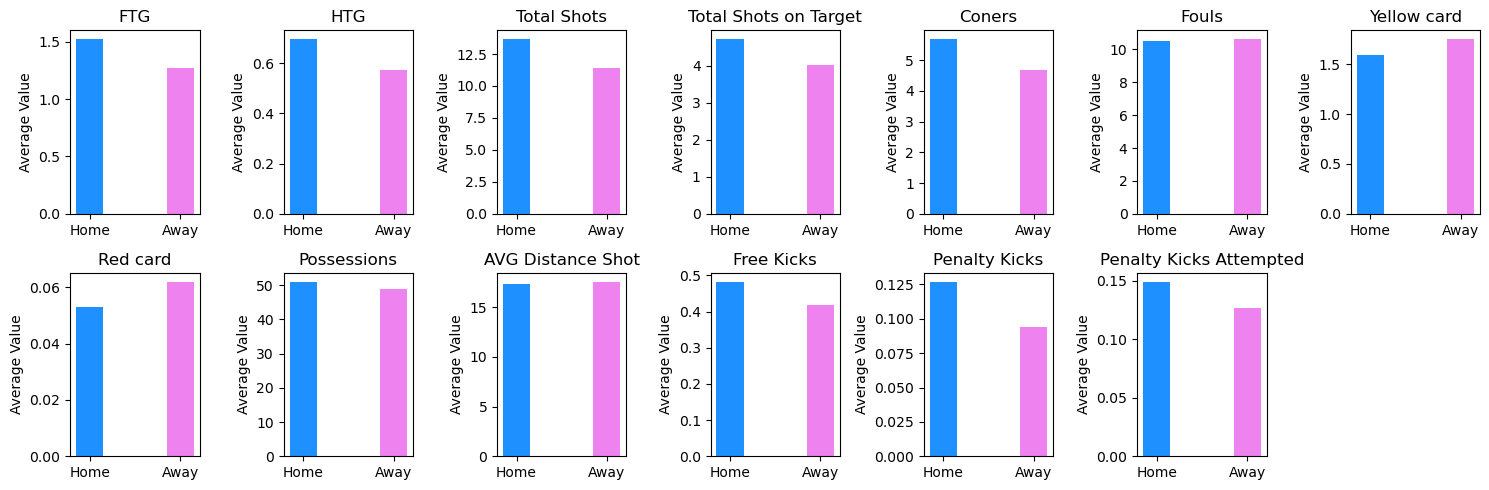

In [1302]:
def plot_average_values():

    column_names = ['FTG', 'HTG', 'Total Shots', 'Total Shots on Target', 'Coners', 'Fouls',
                    'Yellow card', 'Red card', 'Possessions', 'AVG Distance Shot',
                    'Free Kicks', 'Penalty Kicks', 'Penalty Kicks Attempted']

    home_stats = merged_df[['FTHG', 'HTHG', 'HS', 'HST', 'HC', 'HF', 'HY',
                            'HR', 'poss_H', 'dist_H', 'fk_H', 'pk_H', 'pkatt_H']].mean()

    away_stats = merged_df[['FTAG', 'HTAG', 'AS', 'AST', 'AC', 'AF', 'AY',
                            'AR', 'poss_A', 'dist_A', 'fk_A', 'pk_A', 'pkatt_A']].mean()
    # subplots
    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(15, 5))
    fig.delaxes(axes[1,6]) # The indexing is zero-based here
    axes = axes.flatten()

    # plotting each feature separately
    for i, column in enumerate(column_names):
        pos = np.arange(2)
        bar_width = 0.3
        home_stat = home_stats[i]
        away_stat = away_stats[i]

        axes[i].bar(pos, [home_stat, away_stat], width=bar_width, color=['dodgerblue', 'violet'], capsize=7)
        axes[i].set_title(column)
        axes[i].set_xticks(pos)
        axes[i].set_xticklabels(['Home', 'Away'])
        axes[i].set_ylabel('Average Value')

    plt.tight_layout()
    plt.show()

# We want to see whether the indicators favor the home team or the away team.
plot_average_values()
# There is indeed advantage for home team

In [1303]:
merged_df.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF',
       'HY', 'AY', 'HR', 'AR', 'poss_H', 'dist_H', 'fk_H', 'pk_H', 'pkatt_H',
       'poss_A', 'dist_A', 'fk_A', 'pk_A', 'pkatt_A'],
      dtype='object')

In [1304]:
# Get non numberic columns
not_numeric_cols = list(set(merged_df.columns) - set(numeric_cols))
print(not_numeric_cols)

['HomeTeam', 'AwayTeam', 'Date', 'FTR', 'HTR', 'Referee']


In [1305]:
print("Total number of columns", len(merged_df.columns))
print("Number of numerical columns", len(numeric_cols))

Total number of columns 32
Number of numerical columns 26


In [1306]:
# Add average features
def add_avg_features_in_last_five_games(df):
    selected_features = list(set(df.columns) - set(not_numeric_cols))

    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        current_date = row['Date']

        # Matches that occurred before the current match
        previous_matches_team_a = df[(df['HomeTeam'] == home_team) & (df['Date'] < current_date)][selected_features]
        previous_matches_team_b = df[(df['AwayTeam'] == away_team) & (df['Date'] < current_date)][selected_features]

        # Calculate mean for available matches up to 5,
        mean_team_a = previous_matches_team_a.tail(5).mean() if len(previous_matches_team_a) >= 5 else previous_matches_team_a.mean()
        mean_team_b = previous_matches_team_b.tail(5).mean() if len(previous_matches_team_b) >= 5 else previous_matches_team_b.mean()

        # Total mean
        total_mean = pd.concat([
            mean_team_a,
            mean_team_b
        ], axis=1).mean(axis=1)

        total_mean = pd.DataFrame(total_mean).transpose()
        # name the columns
        total_mean.columns = [f'{col}_avg' for col in total_mean.columns]

        # Concatenate the total mean values to the original DataFrame
        df.loc[index, total_mean.columns] = total_mean.values.flatten()

    return df

In [1307]:
merged_df = add_avg_features_in_last_five_games(merged_df)

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF',
       'HY', 'AY', 'HR', 'AR', 'poss_H', 'dist_H', 'fk_H', 'pk_H', 'pkatt_H',
       'poss_A', 'dist_A', 'fk_A', 'pk_A', 'pkatt_A', 'pk_H_avg', 'HS_avg',
       'FTAG_avg', 'AS_avg', 'poss_H_avg', 'AC_avg', 'HST_avg', 'AST_avg',
       'HTHG_avg', 'pkatt_H_avg', 'HF_avg', 'HC_avg', 'pkatt_A_avg',
       'fk_H_avg', 'dist_H_avg', 'poss_A_avg', 'FTHG_avg', 'pk_A_avg',
       'HR_avg', 'AR_avg', 'fk_A_avg', 'dist_A_avg', 'HY_avg', 'AY_avg',
       'HTAG_avg', 'AF_avg'],
      dtype='object')

In [1308]:
# Check the calculation is correct when the team at home(e.g. Arsenal)
merged_df.loc[(merged_df['HomeTeam'] == "Arsenal")][["Date", "HomeTeam",
                                                     "AwayTeam", "FTHG", 'FTHG_avg']].head(10)

,Date,HomeTeam,AwayTeam,FTHG,FTHG_avg
9,2018-08-12,Arsenal,Man City,0.0,NaN
21,2018-08-25,Arsenal,West Ham,3.0,2.000000
58,2018-09-23,Arsenal,Everton,2.0,1.750000
61,2018-09-29,Arsenal,Watford,2.0,1.333333
89,2018-10-22,Arsenal,Leicester,3.0,1.750000
100,2018-11-03,Arsenal,Liverpool,1.0,1.300000
119,2018-11-11,Arsenal,Wolves,1.0,1.500000
139,2018-12-02,Arsenal,Tottenham,4.0,1.200000
157,2018-12-08,Arsenal,Huddersfield,1.0,2.000000
172,2018-12-22,Arsenal,Burnley,3.0,2.200000


In [1309]:
# Check the calculation is correct when the team at away(e.g. Arsenal)
merged_df.loc[(merged_df['AwayTeam'] == "West Ham")][["Date", "HomeTeam",
                                                     "AwayTeam", "FTHG", 'FTHG_avg']].head(10)

,Date,HomeTeam,AwayTeam,FTHG,FTHG_avg
7,2018-08-12,Liverpool,West Ham,4.0,NaN
21,2018-08-25,Arsenal,West Ham,3.0,2.000000
48,2018-09-16,Everton,West Ham,1.0,2.500000
70,2018-10-05,Brighton,West Ham,1.0,2.333333
94,2018-10-27,Leicester,West Ham,1.0,2.000000
110,2018-11-10,Huddersfield,West Ham,1.0,1.100000
135,2018-12-01,Newcastle,West Ham,0.0,1.100000
164,2018-12-15,Fulham,West Ham,0.0,1.000000
189,2018-12-27,Southampton,West Ham,1.0,0.900000
197,2018-12-30,Burnley,West Ham,2.0,0.700000


Create features based on previous data

In [1311]:
# Add face to face average features
def add_avg_features_in_last_two_games_face(df):
    ending_with_avg_features = [col for col in merged_df.columns if col.endswith('_avg')]
    selected_features = list(set(merged_df.columns) - set(not_numeric_cols) - set(ending_with_avg_features))

    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        current_date = row['Date']

        previous_matches_team_a_and_b = df[
            (df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team) & (df['Date'] < current_date)
        ][selected_features]

        mean_team_a_and_b = previous_matches_team_a_and_b.tail(2).mean() if len(previous_matches_team_a_and_b) >= 2 else previous_matches_team_a_and_b.mean()

        mean_values = mean_team_a_and_b.squeeze()

        mean_df = pd.DataFrame(mean_values).transpose()

        mean_df.columns = [f'{col}_avg_face' for col in mean_df.columns]

        # Concatenate the total mean values to the original DataFrame
        df.loc[index, mean_df.columns] = mean_df.values.flatten()

    return df

In [1312]:
merged_df = add_avg_features_in_last_two_games_face(merged_df)

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF',
       'HY', 'AY', 'HR', 'AR', 'poss_H', 'dist_H', 'fk_H', 'pk_H', 'pkatt_H',
       'poss_A', 'dist_A', 'fk_A', 'pk_A', 'pkatt_A', 'pk_H_avg', 'HS_avg',
       'FTAG_avg', 'AS_avg', 'poss_H_avg', 'AC_avg', 'HST_avg', 'AST_avg',
       'HTHG_avg', 'pkatt_H_avg', 'HF_avg', 'HC_avg', 'pkatt_A_avg',
       'fk_H_avg', 'dist_H_avg', 'poss_A_avg', 'FTHG_avg', 'pk_A_avg',
       'HR_avg', 'AR_avg', 'fk_A_avg', 'dist_A_avg', 'HY_avg', 'AY_avg',
       'HTAG_avg', 'AF_avg', 'pk_H_avg_face', 'HS_avg_face', 'FTAG_avg_face',
       'AS_avg_face', 'poss_H_avg_face', 'AC_avg_face', 'HST_avg_face',
       'AST_avg_face', 'HTHG_avg_face', 'pkatt_H_avg_face', 'HF_avg_face',
       'HC_avg_face', 'pkatt_A_avg_face', 'fk_H_avg_face', 'dist_H_avg_face',
       'poss_A_avg_face', 'FTHG_avg_face', 'pk_A_avg_face', 'HR_avg_face',
       'AR_avg_face', 'fk_A

In [1313]:
merged_df.loc[(merged_df['HomeTeam'] == "Arsenal") & (merged_df['AwayTeam'] == "Wolves")][["Date", "HomeTeam",
                                                     "AwayTeam", "FTHG", 'FTHG_avg', 'FTHG_avg_face']].head(10)

,Date,HomeTeam,AwayTeam,FTHG,FTHG_avg,FTHG_avg_face
119,2018-11-11,Arsenal,Wolves,1.0,1.5,NaN
484,2019-11-02,Arsenal,Wolves,1.0,1.5,1.0
852,2020-11-29,Arsenal,Wolves,1.0,1.4,1.0
1385,2022-02-24,Arsenal,Wolves,2.0,1.0,1.0
1888,2023-05-28,Arsenal,Wolves,5.0,2.7,1.5


In [1314]:
len(merged_df.columns) # 32 + 26 + 26 = 84

84

Convert Date to Fourier Feature

In [ ]:
def days_from_january_1_column(date_column):
    # January 1st of the same year
    january_1 = pd.to_datetime(date_column.dt.year.astype(str) + '-01-01')

    # Calculate the difference in days
    days_difference = (date_column - january_1).dt.days + 1

    return days_difference

In [ ]:
def generate_fourier_features_for_date(df):
    # normalized time within the period
    date_num = days_from_january_1_column(df['Date'])
    df['normalized_time'] = date_num / 365

    # Fourier Features
    df['sin_time'] = np.sin(2 * np.pi * df['normalized_time'])
    df['cos_time'] = np.cos(2 * np.pi * df['normalized_time'])

    # Drop the temporary column used for normalization
    df.drop('normalized_time', axis=1, inplace=True)

    return df

merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%Y-%m-%d')
merged_df = generate_fourier_features_for_date(merged_df)

# Imputation

In [1315]:
print(merged_df.isna().sum())

Date                 0
HomeTeam             0
AwayTeam             0
FTHG                 0
FTAG                 0
                  ... 
dist_A_avg_face    664
HY_avg_face        664
AY_avg_face        664
HTAG_avg_face      664
AF_avg_face        664
Length: 84, dtype: int64


Because there are too many missing values, we cannot discard them all. Proceed with imputation.

In [1316]:
# Assuming df is your DataFrame
nan_count_first_row = merged_df.iloc[0].isna().sum()

# Display the number of NaN values in the first row
print("Number of NaN values in the first row:", nan_count_first_row)

Number of NaN values in the first row: 52


In [1317]:
selected_features = list(set(merged_df.columns) - set(not_numeric_cols))
sorted_list = sorted(selected_features)

imputer_mice = IterativeImputer(random_state=42)
numeric_data = imputer_mice.fit_transform(merged_df[sorted_list])

numeric_data_df = pd.DataFrame(numeric_data, columns=sorted_list)

In [1318]:
merged_df = pd.concat([merged_df[not_numeric_cols], numeric_data_df], axis=1)

In [1320]:
# Finally drop the raw features
merged_df = merged_df.drop(numeric_cols, axis=1)

In [1325]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   HomeTeam          1998 non-null   object        
 1   AwayTeam          1998 non-null   object        
 2   Date              1998 non-null   datetime64[ns]
 3   FTR               1998 non-null   object        
 4   HTR               1998 non-null   object        
 5   Referee           1998 non-null   object        
 6   AC_avg            1998 non-null   float64       
 7   AC_avg_face       1998 non-null   float64       
 8   AF_avg            1998 non-null   float64       
 9   AF_avg_face       1998 non-null   float64       
 10  AR_avg            1998 non-null   float64       
 11  AR_avg_face       1998 non-null   float64       
 12  AST_avg           1998 non-null   float64       
 13  AST_avg_face      1998 non-null   float64       
 14  AS_avg            1998 n

<a name='encoding'></a>
## 3.3. Feature Encoding

In [1326]:
data = merged_df.copy()

In [1327]:
data.shape

(1998, 60)

In [1328]:
# Since our objective is to predict future EPL matches,
# we do not have access to the values of 'Referee' and 'HTR' (Half Time Result) at that time.
# Therefore, we exclude/drop these columns from our analysis.
data.drop(columns=['HTR', 'Referee'], inplace=True)

In [1330]:
data['Date'] = pd.to_datetime(data['Date'])

In [1331]:
# Finally drop the 'Date' columns because we encoded time
# do not drop Date from merged_df
data.drop('Date', axis=1, inplace=True)

In [1332]:
# Split the target 'FTR' from the feature data
target_df = data[['FTR']]
features_df = data.drop(['FTR'], axis=1)

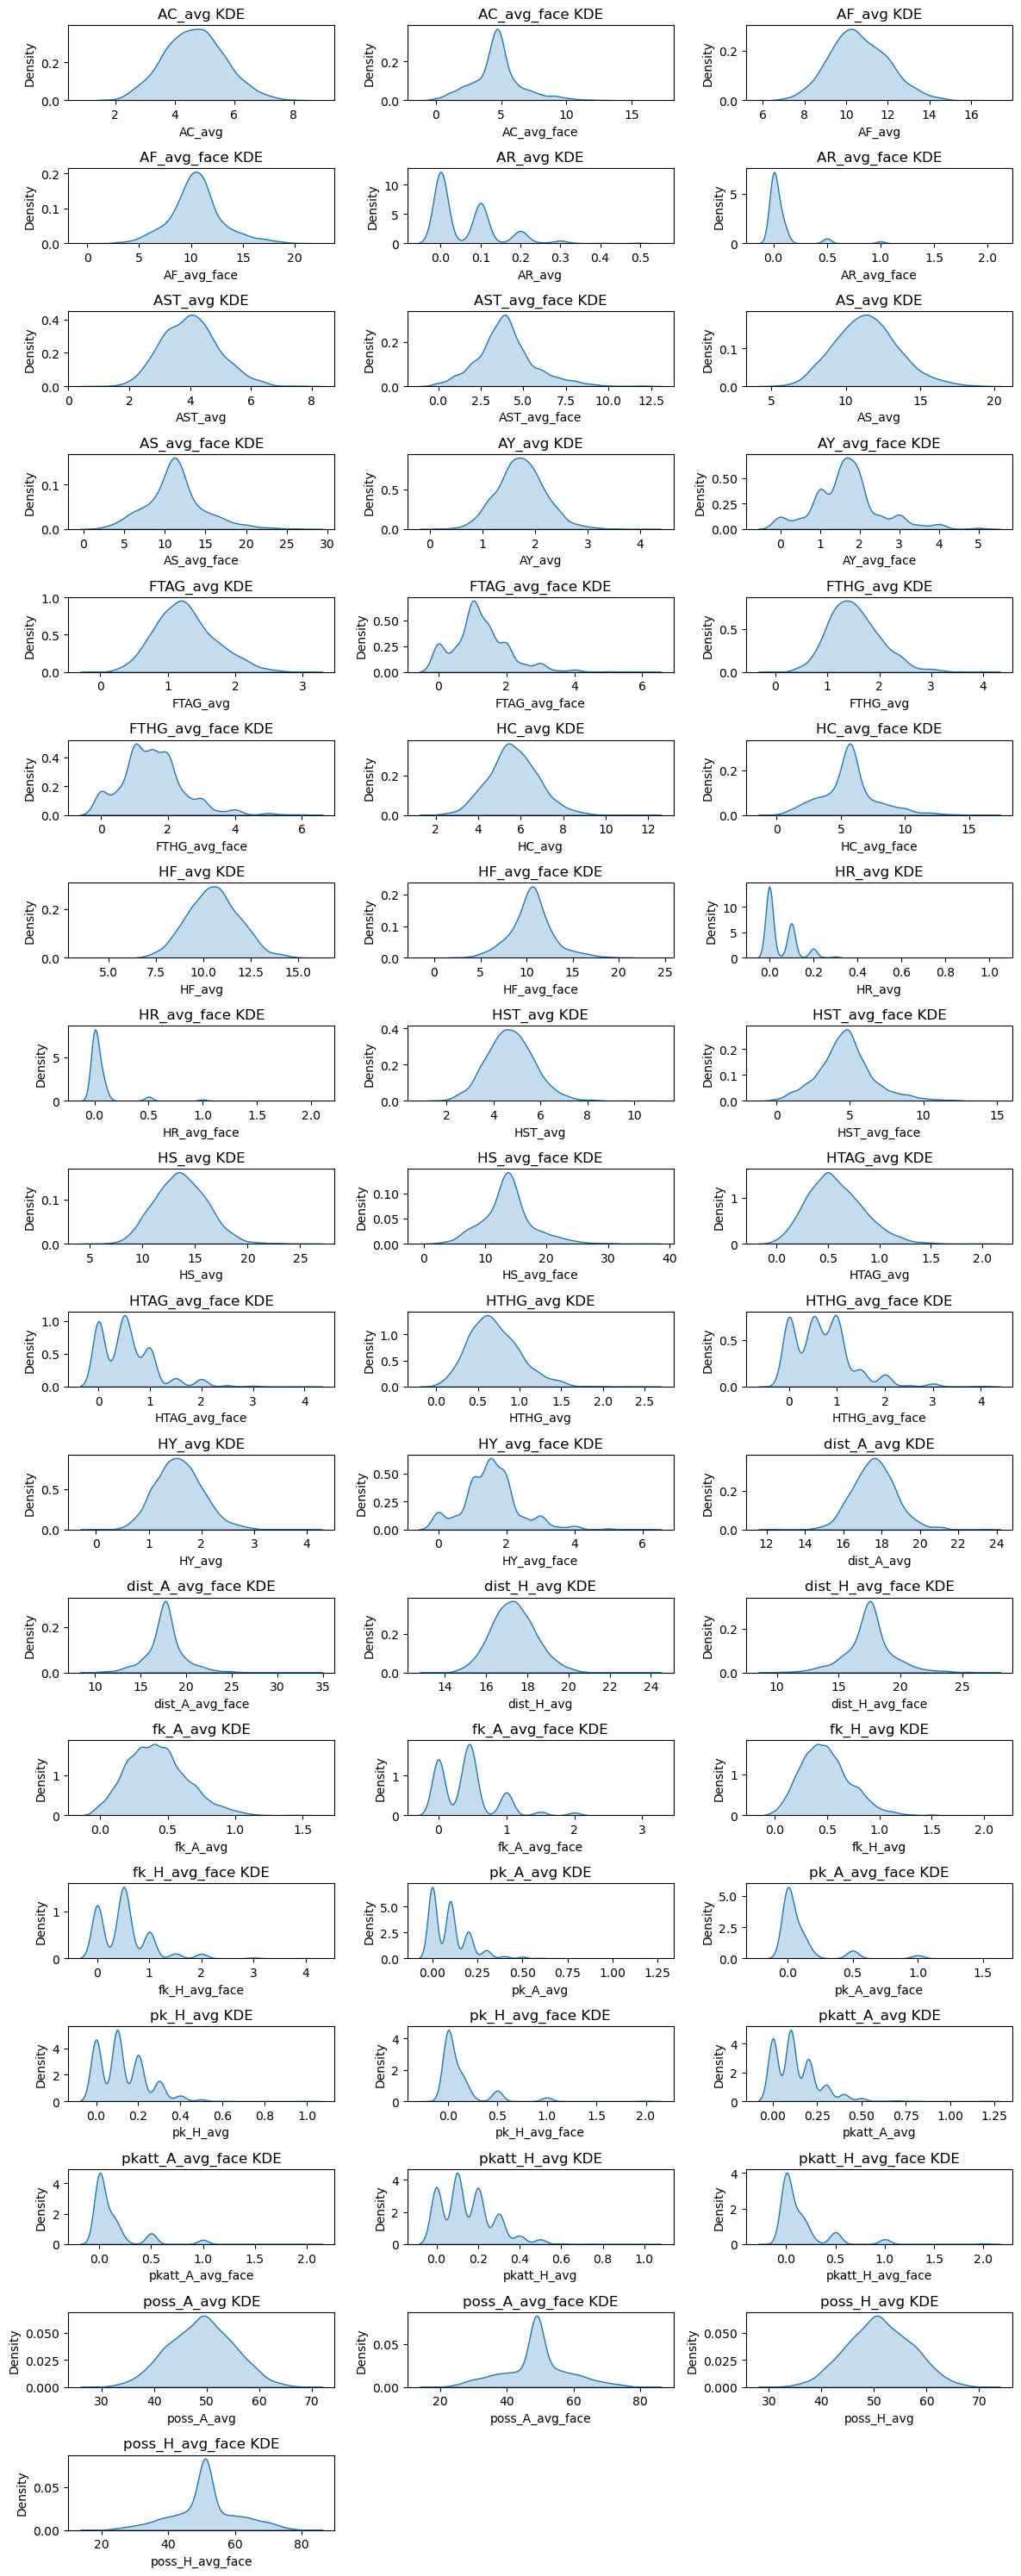

In [1333]:
def displayKDE():
  fig, axes = plt.subplots(nrows=18, ncols=3, figsize=(12, 30))
  fig.delaxes(axes[17,1])
  fig.delaxes(axes[17,2])

  axes = axes.flatten()

  numeric_columns = features_df.select_dtypes(include='number')

  for i, col in enumerate(numeric_columns):
      sns.kdeplot(merged_df[col], fill=True, ax=axes[i])
      axes[i].set_title(f'{col} KDE')

  plt.tight_layout()

  plt.show()

# Check which feature has guassian distribution
displayKDE()

In [1335]:
features_df = pd.get_dummies(features_df, drop_first=False) 

In [1336]:
# Since RandomizedSearchCV supports cross-validation,
# we will split our dataset into an 80:20 ratio for training and testing.
# RandomizedSearchCV will internally perform cross-validation during the hyperparameter search
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=42)
# for the MLP
X_valid, X_test_mlp, y_valid, y_test_mlp = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [1340]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1598 entries, 240 to 1126
Columns: 110 entries, AC_avg to AwayTeam_Wolves
dtypes: bool(56), float64(54)
memory usage: 774.0 KB


In [1341]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 256 to 966
Columns: 110 entries, AC_avg to AwayTeam_Wolves
dtypes: bool(56), float64(54)
memory usage: 193.8 KB


In [1342]:
# One Hot Encode the target
y_train_one_hot = pd.get_dummies(y_train, drop_first=False)
y_test_one_hot = pd.get_dummies(y_test, drop_first=False)
y_valid_one_hot = pd.get_dummies(y_valid, drop_first=False)
y_test_mlp_one_hot = pd.get_dummies(y_test_mlp, drop_first=False)

In [1343]:
# Label Encode the target
label_encoder = LabelEncoder()

y_train_label = label_encoder.fit_transform(y_train.values.ravel())
y_test_label = label_encoder.transform(y_test.values.ravel())

In [1344]:
# actually, all features are following a Gaussian distribution, except for sin_time and cos_time
# because they are discrete, so their distributions do not look like Gaussian.

all_features = list(X_train.columns)
one_hot_features = [s for s in all_features if 'HomeTeam' in s or 'AwayTeam' in s]
not_change_features = ['sin_time', 'cos_time']

gaussian_features = list(set(all_features) - set(one_hot_features + not_change_features))

print(len(gaussian_features)) # Total of 52 features
print(gaussian_features)

52
['dist_H_avg_face', 'AS_avg', 'HF_avg', 'HY_avg', 'HST_avg_face', 'pk_H_avg', 'poss_A_avg', 'AST_avg_face', 'dist_A_avg', 'pk_A_avg_face', 'poss_A_avg_face', 'HS_avg', 'fk_A_avg', 'fk_H_avg_face', 'AC_avg', 'pkatt_A_avg_face', 'HST_avg', 'HTHG_avg_face', 'HR_avg_face', 'HC_avg_face', 'HTAG_avg', 'fk_A_avg_face', 'HC_avg', 'pkatt_H_avg', 'FTHG_avg', 'AF_avg', 'HTAG_avg_face', 'poss_H_avg_face', 'FTAG_avg_face', 'AY_avg_face', 'pk_H_avg_face', 'pkatt_A_avg', 'HF_avg_face', 'fk_H_avg', 'HY_avg_face', 'AST_avg', 'HS_avg_face', 'pk_A_avg', 'FTAG_avg', 'AS_avg_face', 'FTHG_avg_face', 'HR_avg', 'AY_avg', 'poss_H_avg', 'HTHG_avg', 'dist_H_avg', 'pkatt_H_avg_face', 'AR_avg', 'AC_avg_face', 'dist_A_avg_face', 'AR_avg_face', 'AF_avg_face']


In [1345]:
# Scale the features
standardScaler = StandardScaler()

X_train.loc[:, gaussian_features] = standardScaler.fit_transform(X_train.loc[:, gaussian_features])
X_test.loc[:, gaussian_features] = standardScaler.transform(X_test.loc[:, gaussian_features])
X_valid.loc[:, gaussian_features] = standardScaler.transform(X_valid.loc[:, gaussian_features])
X_test_mlp.loc[:, gaussian_features] = standardScaler.transform(X_test_mlp.loc[:, gaussian_features])

<a name='selection'></a>
## 3.3. Feature Selection

In [1347]:
# Get features except for team names
all_features = list(X_train.columns)
teamname_features = [s for s in all_features if 'HomeTeam' in s or 'AwayTeam' in s]
not_change_features = ['sin_time', 'cos_time']

features_selection_col = list(set(all_features) - set(teamname_features))

print(len(features_selection_col)) # Total of 26 features
print(features_selection_col)

54
['dist_H_avg_face', 'AS_avg', 'HF_avg', 'HY_avg', 'HST_avg_face', 'pk_H_avg', 'poss_A_avg', 'AST_avg_face', 'dist_A_avg', 'pk_A_avg_face', 'poss_A_avg_face', 'HS_avg', 'fk_A_avg', 'fk_H_avg_face', 'AC_avg', 'pkatt_A_avg_face', 'HST_avg', 'HTHG_avg_face', 'HR_avg_face', 'HC_avg_face', 'HTAG_avg', 'fk_A_avg_face', 'HC_avg', 'pkatt_H_avg', 'FTHG_avg', 'AF_avg', 'HTAG_avg_face', 'poss_H_avg_face', 'FTAG_avg_face', 'AY_avg_face', 'pk_H_avg_face', 'pkatt_A_avg', 'sin_time', 'HF_avg_face', 'fk_H_avg', 'HY_avg_face', 'AST_avg', 'HS_avg_face', 'pk_A_avg', 'FTAG_avg', 'AS_avg_face', 'FTHG_avg_face', 'HR_avg', 'AY_avg', 'cos_time', 'poss_H_avg', 'HTHG_avg', 'dist_H_avg', 'pkatt_H_avg_face', 'AR_avg', 'AC_avg_face', 'dist_A_avg_face', 'AR_avg_face', 'AF_avg_face']


In [1348]:
# We will perform feature selection using a training set, since it is larger than valid set
# Use features except for teams names
feature_selection_X_train = X_train

# Count features to identify which one is mostly useful
feature_dict = {key: 0 for key in feature_selection_X_train.columns}

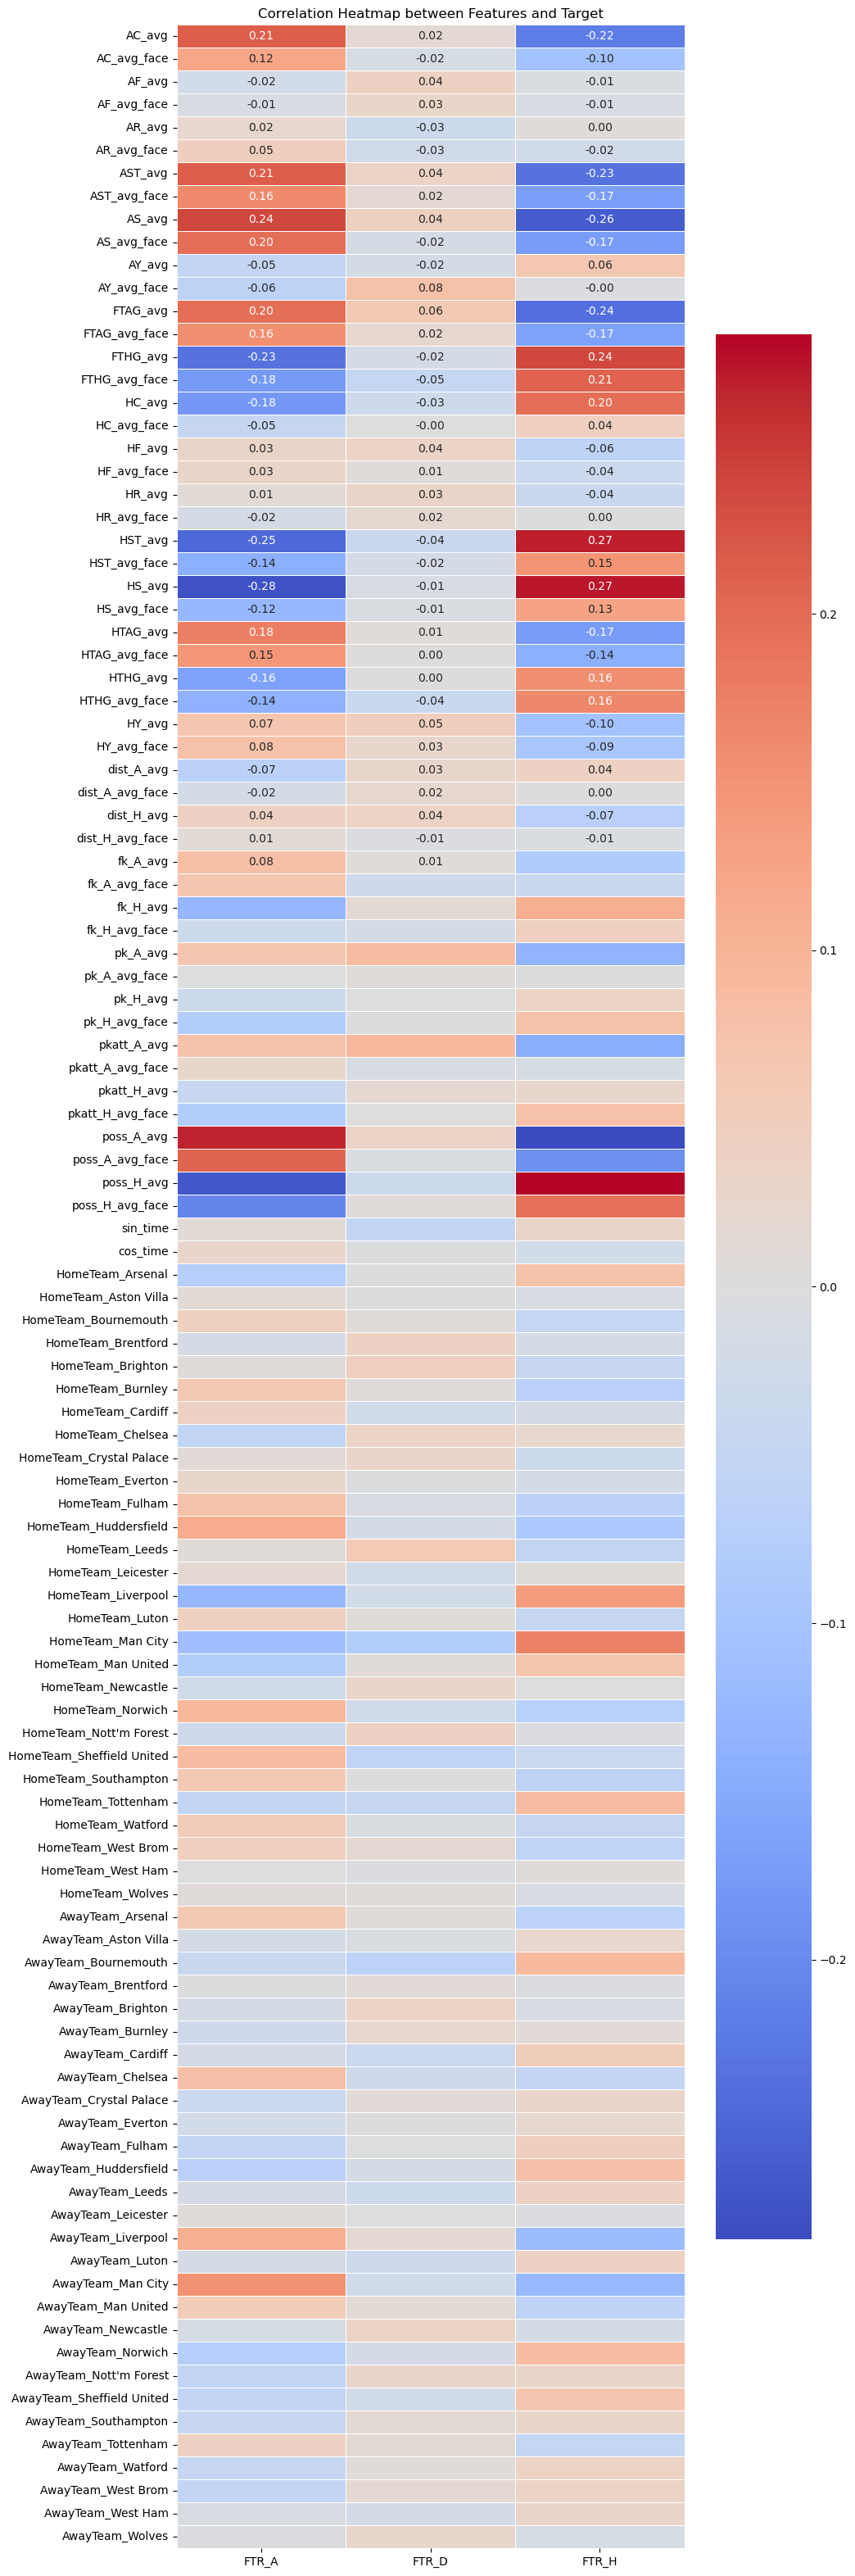

In [1349]:
# Concatenate X_train and Y_train
combined_df = pd.concat([feature_selection_X_train, y_train_one_hot], axis=1)

# Calculate the correlation matrix
correlation_matrix = combined_df.corr()
# Extract the correlation with respect to the original features
correlation_with_targets = correlation_matrix.loc[feature_selection_X_train.columns, y_train_one_hot.columns]

# Create a heatmap
plt.figure(figsize=(10, 40))
sns.heatmap(correlation_with_targets, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title("Correlation Heatmap between Features and Target")
plt.show()

<a name='wrapper'></a>
### 3.3.1. Wrapper Method

In [1350]:
# Wrapper method measures usefulness of Feature subset
solver = 'lbfgs' if len(feature_selection_X_train) < 10000 else 'sag'  # adjust this based on dataset size

# Create an RFE selector
rfe_selector = RFE(estimator=LogisticRegression(multi_class='auto', solver=solver), n_features_to_select=1000, step=10, verbose=5)

# Fit the RFE selector
rfe_selector.fit(feature_selection_X_train, y_train_label)

# Get features (here I want to see all in order of importance)
rfe_support = rfe_selector.get_support()
rfe_feature = feature_selection_X_train.loc[:, rfe_support].columns.tolist()

# Extract the importance from the fitted model
coefficients = rfe_selector.estimator_.coef_[0]

# Generate a feature importance set and sort it
feature_importance = list(zip(rfe_feature, coefficients))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

# Add 10 highest importance features to feature_dict
# Print features and their absolute correlation values
print("Feature Importance:")
count = 0
for feature, importance in feature_importance:
    if count < 10:
        feature_dict[f"{feature}"] += 1
        count += 1
    print(f"{feature}: {importance}")

Feature Importance:
HomeTeam_Huddersfield: 1.2464140837951854
AwayTeam_Huddersfield: -0.8781080776671417
AwayTeam_Man City: 0.7001845401199658
HomeTeam_Liverpool: -0.6936578875747406
HomeTeam_Norwich: 0.62562016165957
AwayTeam_Liverpool: 0.5914956121062229
HomeTeam_Sheffield United: 0.5836109354061376
HomeTeam_Luton: 0.5697454956937895
AwayTeam_West Brom: -0.5652172057087993
HomeTeam_Nott'm Forest: -0.5396365917409339
AwayTeam_Norwich: -0.5386829459873068
HomeTeam_Cardiff: 0.5329308819272672
HomeTeam_Man United: -0.5318452794640822
HomeTeam_Arsenal: -0.5023796540103644
HomeTeam_Brentford: -0.40703102515070827
AwayTeam_Nott'm Forest: -0.3971899435670937
HomeTeam_Newcastle: -0.39411354032629903
AwayTeam_Man United: 0.37464406658617005
AwayTeam_Watford: -0.36223285191302446
HomeTeam_Watford: 0.3584024886728684
HomeTeam_Fulham: 0.3555866833639088
HomeTeam_Man City: -0.35128088372245975
AwayTeam_Chelsea: 0.324689507157396
HomeTeam_Chelsea: -0.28011925071680055
HS_avg: -0.26473225386933696
A

<a name='filter'></a>
### 3.3.2. Filter Method

This methods are divided into two main categories: Univariate Filter Methods and Multivariate Filter Methods. Univariate methods evaluate and rank individual features independently based on criteria like Fisher score, mutual information, or feature variance. However, these methods may neglect inter-feature relationships, leading to the selection of potentially redundant features. In contrast, Multivariate Filter Methods take into account the mutual relationships between features, allowing for the identification and removal of redundant and correlated features from the dataset.

<a name='univariate_filter'></a>
#### 3.3.2.1. Pearson Correlation (Univariate Filter)

In [1351]:
def pearson_cor_selector(X, y):
    cor_list = []
    # Calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append((i, np.abs(cor)))

    # Sort features based on absolute correlation values
    cor_list.sort(key=lambda x: x[1], reverse=True)

    # Add 10 highest importance features to feature_dict
    # Print features and their absolute correlation values
    count = 0
    for feature, correlation in cor_list:
        print(f"{feature}: {correlation}")
        if count < 10:
            feature_dict[f"{feature}"] += 1
            count += 1

pearson_cor_selector(feature_selection_X_train, y_train_label)

poss_H_avg: 0.3034586657538584
poss_A_avg: 0.3034549447748375
HS_avg: 0.3031694479500096
HST_avg: 0.2844294567449511
AS_avg: 0.2755062740065184
FTHG_avg: 0.26040895626008
AST_avg: 0.2475567322319228
FTAG_avg: 0.23956365528286927
AC_avg: 0.2381926614023189
poss_H_avg_face: 0.2190805234616238
poss_A_avg_face: 0.21907536121346205
FTHG_avg_face: 0.21328983329236914
HC_avg: 0.20710713017461538
AS_avg_face: 0.2026901594054905
HTAG_avg: 0.19224219539814835
AST_avg_face: 0.18185140394061655
FTAG_avg_face: 0.1778244749430019
HTHG_avg: 0.17597267803154662
HTHG_avg_face: 0.16663242211480148
HST_avg_face: 0.16061792161612212
HomeTeam_Man City: 0.15939486622530435
HTAG_avg_face: 0.15771281024426106
AwayTeam_Man City: 0.15125587785064123
HomeTeam_Liverpool: 0.1458778778311783
HS_avg_face: 0.1384333484119234
fk_H_avg: 0.13030720691806
AwayTeam_Liverpool: 0.1256341684075954
AC_avg_face: 0.12496477278591378
pkatt_A_avg: 0.12142430781974296
HomeTeam_Huddersfield: 0.11191763521823692
pk_A_avg: 0.11147487

<a name='multivariate_filter'></a>
#### 3.3.2.2. Removing Correlated Features (Multivariate Filter)

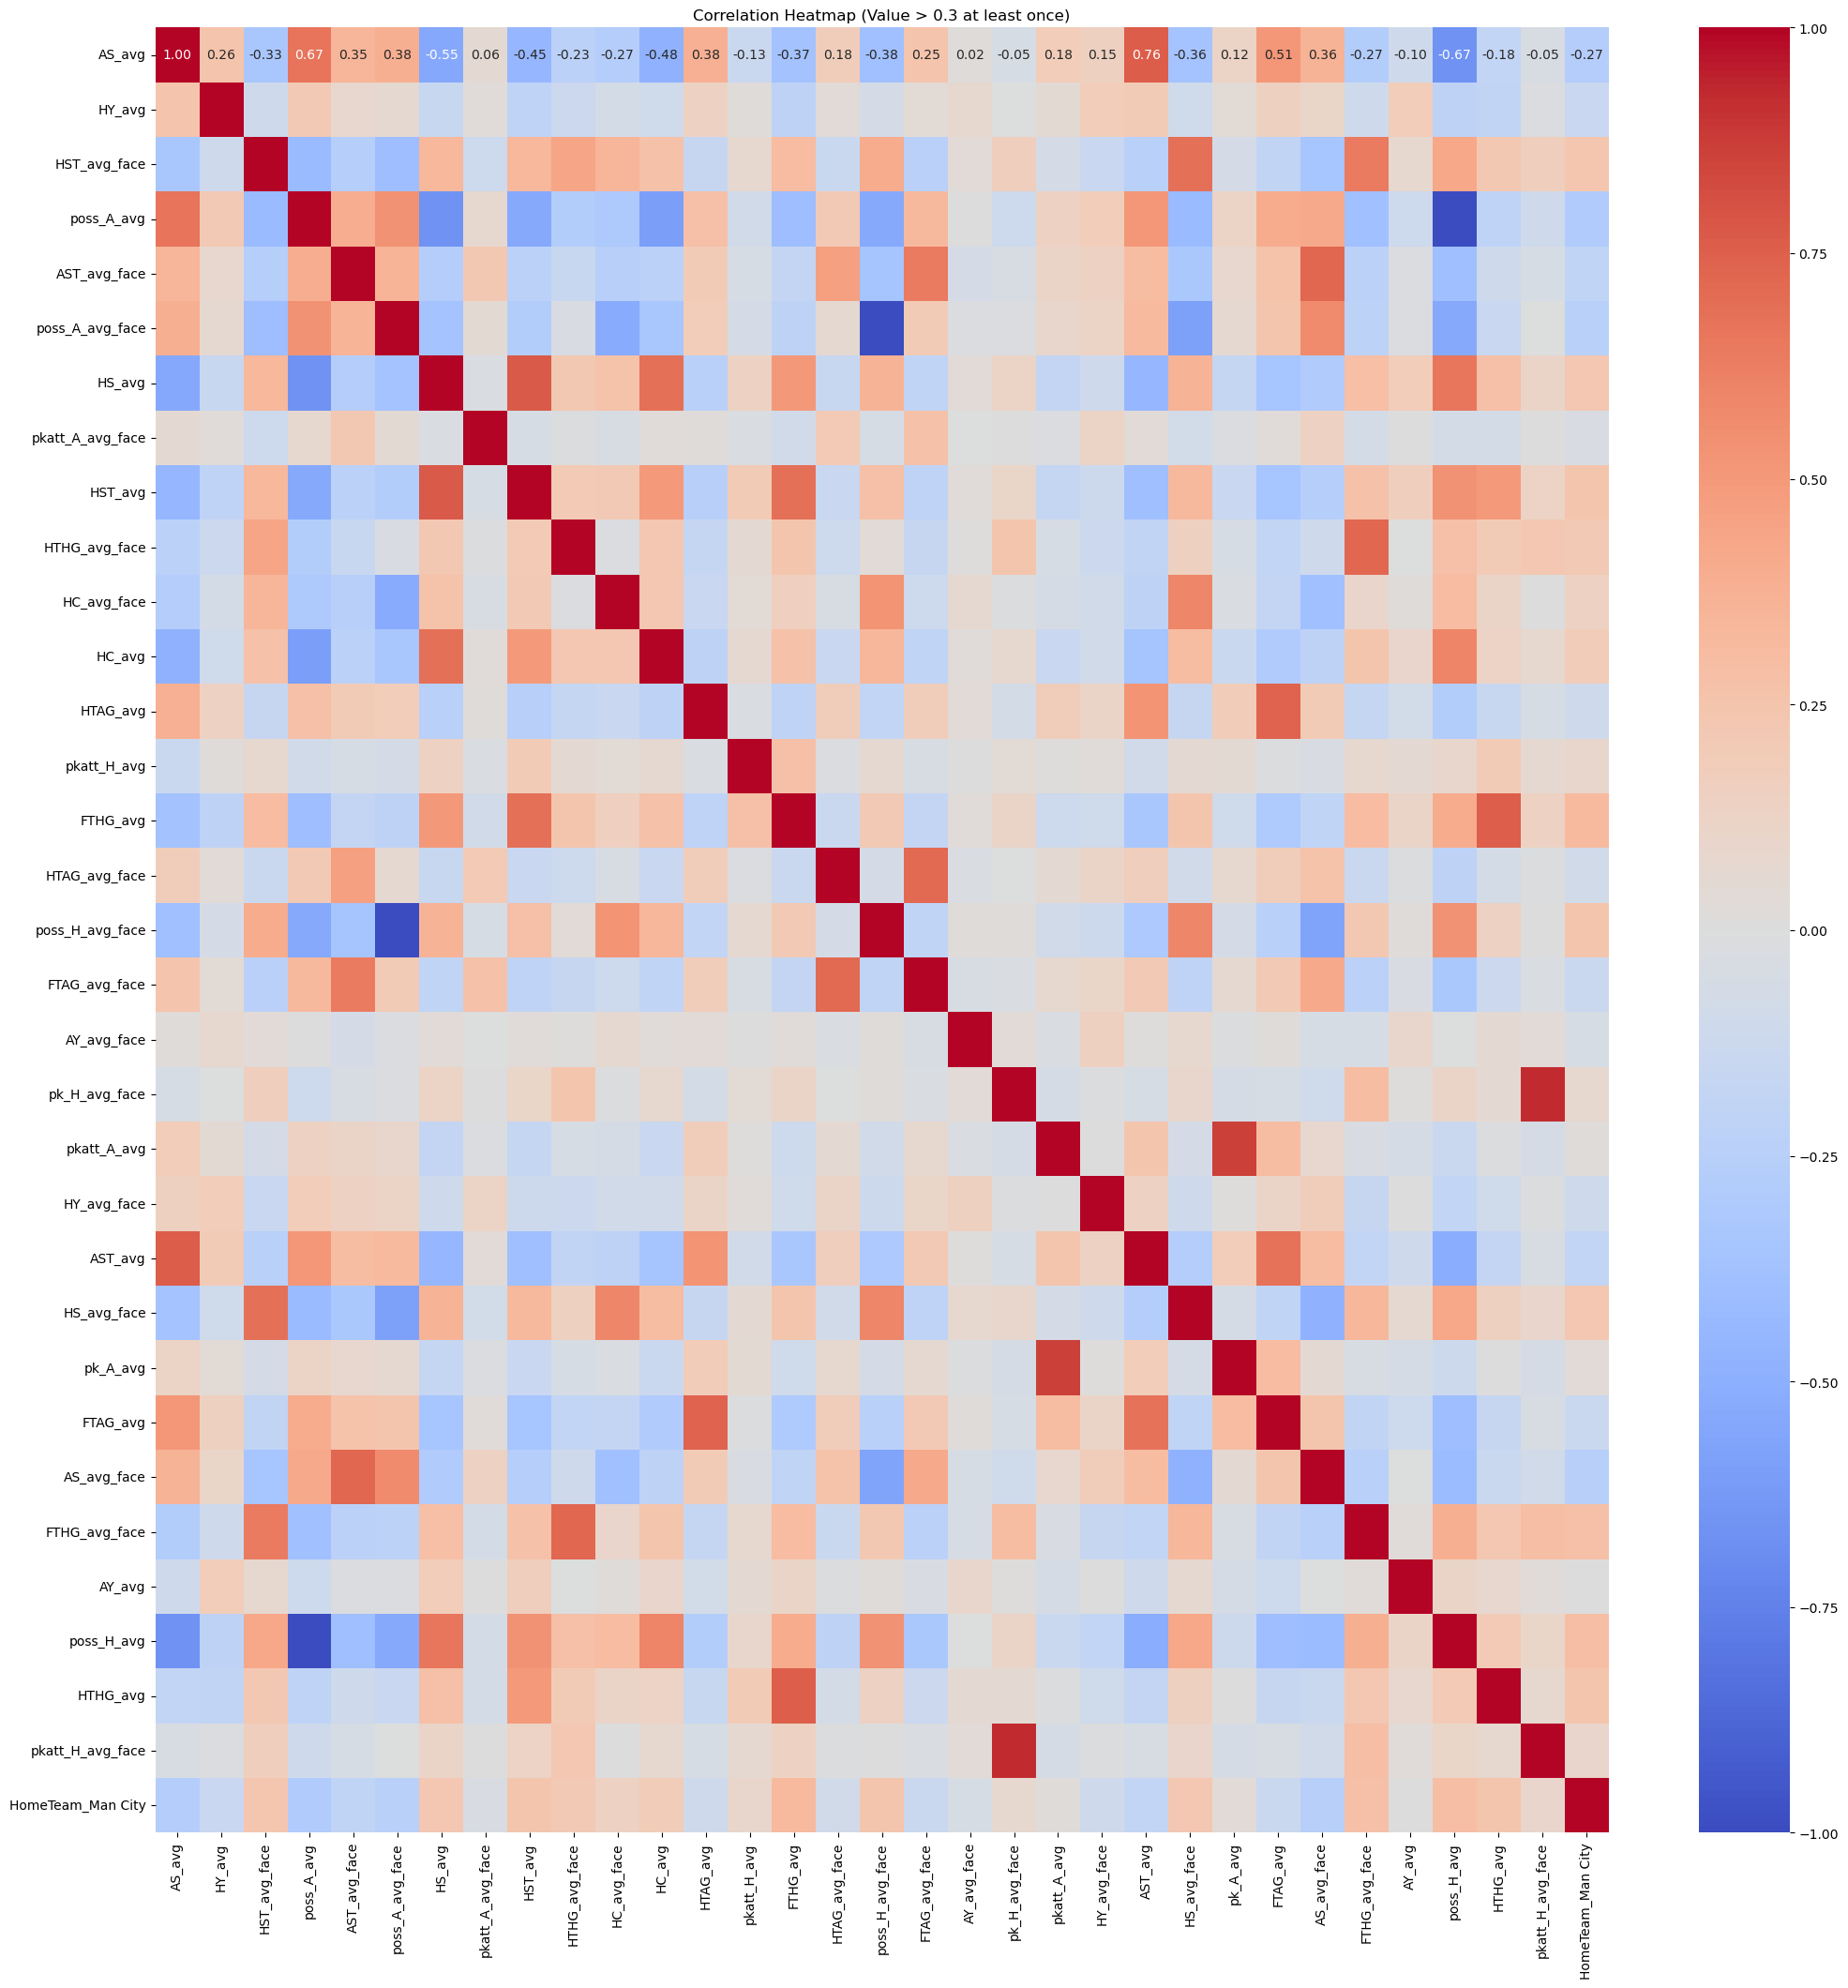

{'pkatt_A_avg_face', 'poss_H_avg', 'pkatt_A_avg', 'pkatt_H_avg_face', 'pkatt_H_avg', 'poss_H_avg_face'}


In [1352]:
def get_removing_cor_features(X):
  correlated_features = set()
  correlation_matrix = X.corr()
  heatmap_features = set()

  for i in range(len(correlation_matrix.columns)):
      for j in range(i):
          if abs(correlation_matrix.iloc[i, j]) > 0.8:
              colname = correlation_matrix.columns[i]
              correlated_features.add(colname)

          if abs(correlation_matrix.iloc[i, j]) > 0.3:
              colname = correlation_matrix.columns[i]
              heatmap_features.add(colname)

  down_scale_data = X[list(heatmap_features)]
  correlation_matrix_down_scale = down_scale_data.corr()

  plt.figure(figsize=(25, 25))
  sns.heatmap(correlation_matrix_down_scale, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
  plt.title("Correlation Heatmap (Value > 0.3 at least once)")
  plt.show()

  # {'AS_avg', 'HST_avg', 'pkatt_A_avg', 'pkatt_H_avg'}

  # We can consider removing the columns identified as highly correlated.
  # For instance, 'pkatt' is highly correlated with 'pk,' and 'poss_A' is correlated with 'poss_H'
  # since their sum is fixed at 100%.
  print(correlated_features)

get_removing_cor_features(feature_selection_X_train)

<a name='embedded'></a>
### 3.3.3. Embedded method

<a name='elastic'></a>
#### 3.3.3.1. Elastic Net

In [1353]:
# Elastic Net model
alpha = 0.1  # regularization strength
l1_ratio = 0.0  # ratio of L1 penalty (0 for Ridge, 1 for LASSO) <- you can adjust it
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)

# fitting
elastic_net.fit(feature_selection_X_train, y_train_label)

# get the absolute values of coefficients for feature importance
feature_importance = np.abs(elastic_net.coef_)

# dictionary with feature names and their importance
feature_importance_dict = dict(zip(feature_selection_X_train.columns, feature_importance))

# sort the features based on their importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Add 10 highest importance features to feature_dict
# Print features and their absolute correlation values
count = 0
for feature, importance in sorted_features:
    print(f'{feature}: {importance}')
    if count < 10:
        feature_dict[f"{feature}"] += 1
        count += 1

HC_avg_face: 0.08328960400015857
HS_avg: 0.082188973107797
HomeTeam_Huddersfield: 0.07529774447543944
HomeTeam_Newcastle: 0.06870293609177505
AwayTeam_Liverpool: 0.061686807083105734
HomeTeam_Man United: 0.06050564723966437
FTHG_avg_face: 0.058054287285385336
HomeTeam_Norwich: 0.056231026361628016
AwayTeam_Newcastle: 0.05574579289784197
poss_A_avg_face: 0.05473489145053777
poss_H_avg_face: 0.05458311525482626
HomeTeam_Arsenal: 0.053107065519688496
FTHG_avg: 0.05150609599290828
HTAG_avg_face: 0.0487156265116843
AwayTeam_Bournemouth: 0.047390143965735224
AwayTeam_Norwich: 0.04710112078291311
HomeTeam_West Ham: 0.0468424635609877
HomeTeam_Liverpool: 0.0468058990496319
HomeTeam_Tottenham: 0.046410027692559606
AwayTeam_Man City: 0.04639020592647225
HomeTeam_Man City: 0.04431028592554228
dist_A_avg_face: 0.04316851030411473
AwayTeam_Arsenal: 0.04191531461366544
AwayTeam_Wolves: 0.04176627736067987
HomeTeam_Fulham: 0.04154982769029844
AS_avg_face: 0.0396859976862944
HomeTeam_Southampton: 0.03

<a name='random_forest'></a>
#### 3.3.3.2. Random Forest

In [1354]:
rf_model = RandomForestClassifier(n_estimators=100)

# Fit
rf_model.fit(feature_selection_X_train, y_train_label)

# feature importances
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': feature_selection_X_train.columns, 'Importance': importances})

# sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print
print(feature_importance_df.to_string(index=False))

top_10_features = feature_importance_df.head(10)['Feature'].tolist()

for feature in top_10_features:
    feature_dict[f"{feature}"] += 1

                  Feature  Importance
                   HS_avg    0.029905
               poss_A_avg    0.028159
          poss_H_avg_face    0.025678
              HC_avg_face    0.024203
               poss_H_avg    0.023923
               dist_A_avg    0.023395
                  HST_avg    0.023305
                   AS_avg    0.022995
              AS_avg_face    0.022942
                 FTHG_avg    0.022629
          poss_A_avg_face    0.022216
          dist_H_avg_face    0.021681
                 FTAG_avg    0.021532
          dist_A_avg_face    0.021012
                 sin_time    0.020746
              HS_avg_face    0.020704
               dist_H_avg    0.020456
                  AST_avg    0.020084
                   AC_avg    0.019921
                   HF_avg    0.019835
                 cos_time    0.019751
              AF_avg_face    0.019694
                   AF_avg    0.019530
                   HY_avg    0.018947
                   HC_avg    0.018686
            

Text(0.5, 0, 'Feature Importance')

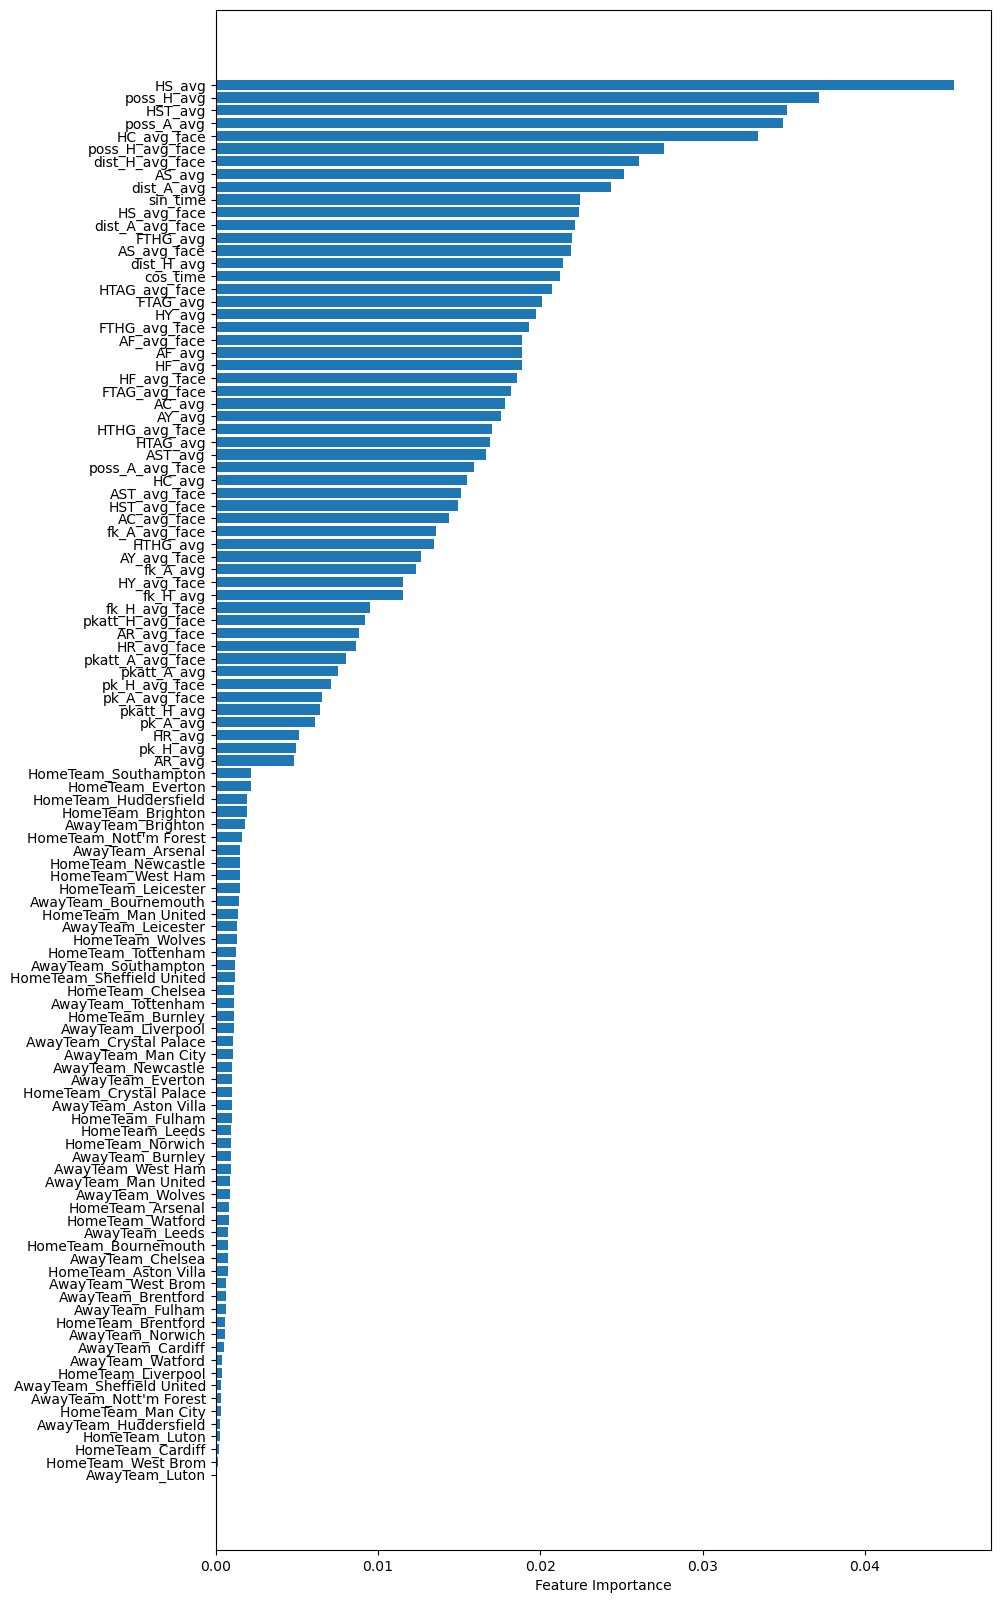

In [1355]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(feature_selection_X_train, y_train_label)
sort = rf.feature_importances_.argsort()
# Set the figure size
plt.figure(figsize=(10, 20))
plt.barh(feature_selection_X_train.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

<a name='final_selection'></a>
### 3.3.4. Final Feature Selection

In [1356]:
# Show top 10 features we can use
top_10_items = sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)[:10]

for key, value in top_10_items:
    print(f"{key}: {value}")

HS_avg: 3
AS_avg: 2
FTHG_avg: 2
HC_avg_face: 2
HST_avg: 2
poss_A_avg: 2
poss_H_avg: 2
poss_H_avg_face: 2
HomeTeam_Huddersfield: 2
HomeTeam_Norwich: 2


In [1357]:
# Show rest of the features we can possibly drop
top_10_columns = [items[0] for items in top_10_items]
rest_columns = list(set(feature_selection_X_train.columns) - set(top_10_columns))
for each in rest_columns:
  print(each)

HomeTeam_Sheffield United
AwayTeam_Burnley
dist_H_avg_face
AwayTeam_Luton
HomeTeam_Southampton
HF_avg
HY_avg
AwayTeam_Arsenal
pk_H_avg
HST_avg_face
dist_A_avg
AwayTeam_Watford
fk_A_avg
AwayTeam_Nott'm Forest
HomeTeam_Nott'm Forest
HomeTeam_Leicester
fk_H_avg_face
HR_avg_face
HomeTeam_Liverpool
HomeTeam_Newcastle
HTAG_avg
fk_A_avg_face
HC_avg
AwayTeam_Sheffield United
AY_avg_face
AwayTeam_West Brom
HomeTeam_Leeds
pkatt_A_avg
AwayTeam_Norwich
AwayTeam_Man United
HomeTeam_Fulham
HS_avg_face
HomeTeam_Arsenal
AwayTeam_Huddersfield
AwayTeam_Liverpool
AY_avg
cos_time
HTHG_avg
pkatt_H_avg_face
HomeTeam_Cardiff
HomeTeam_Wolves
AC_avg_face
HomeTeam_West Ham
AF_avg_face
AwayTeam_Bournemouth
HomeTeam_Brentford
HomeTeam_Chelsea
AST_avg_face
AwayTeam_Crystal Palace
HomeTeam_Tottenham
AwayTeam_Wolves
pk_A_avg_face
poss_A_avg_face
AwayTeam_Fulham
AC_avg
pkatt_A_avg_face
AwayTeam_Leeds
HTHG_avg_face
AwayTeam_Southampton
AwayTeam_Cardiff
HomeTeam_Everton
AwayTeam_West Ham
HomeTeam_Luton
HomeTeam_Man Uni

according to feature selection we dropped 'pkatt_A_avg','pkatt_A_avg_face','pkatt_H_avg','pkatt_H_avg_face','poss_H_avg','poss_H_avg_face' and all teams

In [1358]:
X_train.drop(columns=['pkatt_A_avg','pkatt_A_avg_face','pkatt_H_avg','pkatt_H_avg_face','poss_H_avg','poss_H_avg_face'], inplace=True)
X_train = X_train.drop(columns=X_train.filter(like='HomeTeam').columns)
X_train = X_train.drop(columns=X_train.filter(like='AwayTeam').columns)

X_test.drop(columns=['pkatt_A_avg','pkatt_A_avg_face','pkatt_H_avg','pkatt_H_avg_face','poss_H_avg','poss_H_avg_face'], inplace=True)
X_test = X_test.drop(columns=X_test.filter(like='HomeTeam').columns)
X_test = X_test.drop(columns=X_test.filter(like='AwayTeam').columns)

X_valid.drop(columns=['pkatt_A_avg','pkatt_A_avg_face','pkatt_H_avg','pkatt_H_avg_face','poss_H_avg','poss_H_avg_face'], inplace=True)
X_valid = X_valid.drop(columns=X_valid.filter(like='HomeTeam').columns)
X_valid = X_valid.drop(columns=X_valid.filter(like='AwayTeam').columns)

X_test_mlp.drop(columns=['pkatt_A_avg','pkatt_A_avg_face','pkatt_H_avg','pkatt_H_avg_face','poss_H_avg','poss_H_avg_face'], inplace=True)
X_test_mlp = X_test_mlp.drop(columns=X_test_mlp.filter(like='HomeTeam').columns)
X_test_mlp = X_test_mlp.drop(columns=X_test_mlp.filter(like='AwayTeam').columns)

X_train.columns


Index(['AC_avg', 'AC_avg_face', 'AF_avg', 'AF_avg_face', 'AR_avg',
       'AR_avg_face', 'AST_avg', 'AST_avg_face', 'AS_avg', 'AS_avg_face',
       'AY_avg', 'AY_avg_face', 'FTAG_avg', 'FTAG_avg_face', 'FTHG_avg',
       'FTHG_avg_face', 'HC_avg', 'HC_avg_face', 'HF_avg', 'HF_avg_face',
       'HR_avg', 'HR_avg_face', 'HST_avg', 'HST_avg_face', 'HS_avg',
       'HS_avg_face', 'HTAG_avg', 'HTAG_avg_face', 'HTHG_avg', 'HTHG_avg_face',
       'HY_avg', 'HY_avg_face', 'dist_A_avg', 'dist_A_avg_face', 'dist_H_avg',
       'dist_H_avg_face', 'fk_A_avg', 'fk_A_avg_face', 'fk_H_avg',
       'fk_H_avg_face', 'pk_A_avg', 'pk_A_avg_face', 'pk_H_avg',
       'pk_H_avg_face', 'poss_A_avg', 'poss_A_avg_face', 'sin_time',
       'cos_time'],
      dtype='object')


(1598, 48)

In [1359]:
diff = list(set(data.columns) - set(X_train.columns))
diff

['pkatt_A_avg_face',
 'pkatt_A_avg',
 'poss_H_avg',
 'pkatt_H_avg_face',
 'HomeTeam',
 'AwayTeam',
 'pkatt_H_avg',
 'FTR',
 'poss_H_avg_face']

<a name='methodology_overview'></a>
# 4. Methodology Overview

The models we selected are the following:
1. Random Forest
2. SVM
3. Decision Tree
4. Gaussian Naive Bayes
5. Gradient Boosting
6. Ridge Classifier
7. MLP Classifier
8. Histogram gradient boosting
9. LogisticRegression with softmax
10. Ensemble with all except for Ridge
11. Two custom MLPs

In [1360]:
base_classifiers = [
    (SVC(), {'C':[0.01, 0.1, 1, 10, 100],
             'kernel': ['rbf'],
             'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
             'decision_function_shape': ['ovo', 'ovr'],
             'probability': [True]}),
    (RandomForestClassifier(), {'criterion': ['gini', 'entropy', 'log_loss'],
                                'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                                'max_features': ['sqrt', 'auto'],
                                'bootstrap' : [True, False],
                                'class_weight': ['balanced', 'balanced_subsample']}),
    (DecisionTreeClassifier(), {'criterion': ['gini', 'entropy', 'log_loss'],
                                 'splitter': ['best', 'random'],
                                 'max_features': ['sqrt', 'log2']}),
    (GaussianNB(), {}),
    (GradientBoostingClassifier(), {'loss' : ['log_loss'],
                                    'criterion' : ['friedman_mse', 'squared_error'],
                                    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
                                    'n_estimators' : [100, 200, 300],
                                    'max_features': ['sqrt', 'log2']}),
    (RidgeClassifierCV(), {}),
    (MLPClassifier(), {'hidden_layer_sizes': [(64, 64, 64), (128, 128, 128)],
                       'activation': ['relu'],
                       'solver': ['adam'],
                       'alpha': [0.1, 0.01, 0.001],
                       'max_iter': [1000]}),
    (HistGradientBoostingClassifier(), {'loss': ['log_loss'],
                                        'max_iter': [100, 200, 300],
                                        'max_leaf_nodes': [31, 40, 50],
                                        'learning_rate': [0.001, 0.01, 0.1, 0.2]}),
    (LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=1),
     {'C': [0.001, 0.01, 0.1, 1, 10],
      'penalty': ['l2'],
      'fit_intercept': [True, False]})
]

clf_names = ['Kernel SVM', 'Random Forest', 'DecisionTree Classifier', 'Gaussian Naive Bayes', 'Gradient Boosting',
             'Ridge Classifier', 'MLP Classifier', 'Histogram G. Boosting', 'Logistic Regression']
models =[]

In [1361]:
classifiers = []

for classifier in base_classifiers:
    #t = time.time()
    classifiers.append(RandomizedSearchCV(estimator=classifier[0],
                                          param_distributions=classifier[1],
                                          verbose=4,
                                          cv=5,
                                          n_jobs=-1,
                                          random_state=1,
                                          scoring='accuracy',
                                          n_iter=20))


In [1362]:
# Remove the Ridge Classifier (index 5) from the classifiers list as it doesn't support predict_proba
# This ensures consistency and compatibility within the ensemble model.
indices_to_remove = [2, 3, 5, 6]

model_list = [model for index, model in enumerate(classifiers) if index not in indices_to_remove]
model_name_list = [name for index, name in enumerate(clf_names) if index not in indices_to_remove]

named_classifiers = list(zip(model_name_list, model_list))

# voting classifier (soft)
ensemble_model = VotingClassifier(estimators=named_classifiers, voting='soft')

In [1363]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(MLP, self).__init__() 
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

<a name='training_validation'></a>
# 5. Model Training & Validation

In [1364]:
model_preds = []

for clf_name, clf in zip(clf_names, classifiers):
    t = time.time()
    clf.fit(X_train, y_train_label)
    model_preds.append(clf.predict(X_test))
    models.append(clf)
    print(f'{clf_name} took {round((time.time() - t), 4)} seconds')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV 3/5] END C=10, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, probability=True;, score=0.463 total time=   0.8s
[CV 4/5] END C=10, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, probability=True;, score=0.448 total time=   0.8s
[CV 5/5] END C=10, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, probability=True;, score=0.467 total time=   0.8s
[CV 2/5] END C=10, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, probability=True;, score=0.466 total time=   0.9s
[CV 1/5] END C=10, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, probability=True;, score=0.453 total time=   0.9s
[CV 2/5] END C=0.1, decision_function_shape=ovr, gamma=0.1, kernel=rbf, probability=True;, score=0.447 total time=   0.9s
[CV 1/5] END C=0.1, decision_function_shape=ovr, gamma=0.1, kernel=rbf, probability=True;, score=0.447 total time=   0.9s
[CV 3/5] END C=0.1, decision_function_shape=ovr, gamma=0.1, kernel=rbf, probability=True;, score=0.447 total time=   0.9s
[CV 2/5] END C=0.1,

In [1365]:
# Fit ensemble Model
ensemble_model.fit(X_train, y_train_label)

ensemble_preds = ensemble_model.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 5/5] END C=10, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, probability=True;, score=0.467 total time=   0.6s
[CV 1/5] END C=10, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, probability=True;, score=0.453 total time=   0.7s
[CV 2/5] END C=10, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, probability=True;, score=0.466 total time=   0.7s
[CV 4/5] END C=10, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, probability=True;, score=0.448 total time=   0.7s
[CV 3/5] END C=10, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, probability=True;, score=0.463 total time=   0.7s
[CV 1/5] END C=0.1, decision_function_shape=ovr, gamma=0.1, kernel=rbf, probability=True;, score=0.447 total time=   0.9s
[CV 2/5] END C=0.1, decision_function_shape=ovr, gamma=0.1, kernel=rbf, probability=True;, score=0.447 total time=   0.9s
[CV 3/5] END C=0.1, decision_function_shape=ovr, gamma=0.1, kernel=rbf, probabi

In [1366]:
models.append(ensemble_model)
clf_names.append('Ensemble model')

In [1367]:
# MLP Test Functions
def train_model(model, criterion, optimizer, X_tensor, Y_tensor):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, Y_tensor)
    loss.backward()
    optimizer.step()

def evaluate_model(model, X_tensor):
    model.eval()
    with torch.no_grad():
        pred = model(X_tensor)
        pred_labels = torch.argmax(pred, dim=1)
    return pred_labels

def plot_accuracies(r_train, r_valid, label):
    plt.figure()
    plt.plot(r_train, label='Train Accuracy')
    plt.plot(r_valid, label='Test Accuracy')
    plt.title(label)
    plt.legend()
    plt.show()

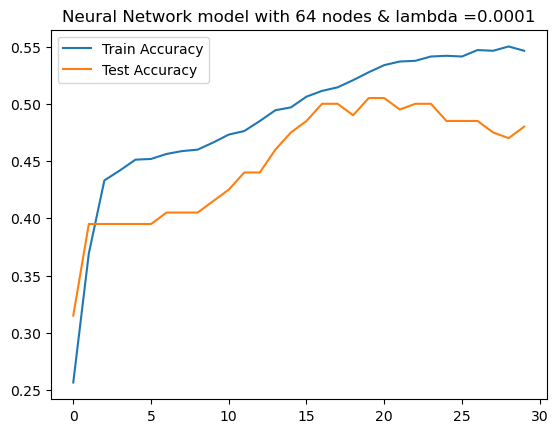

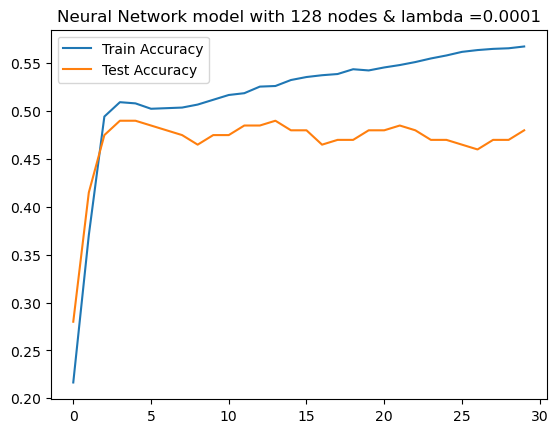

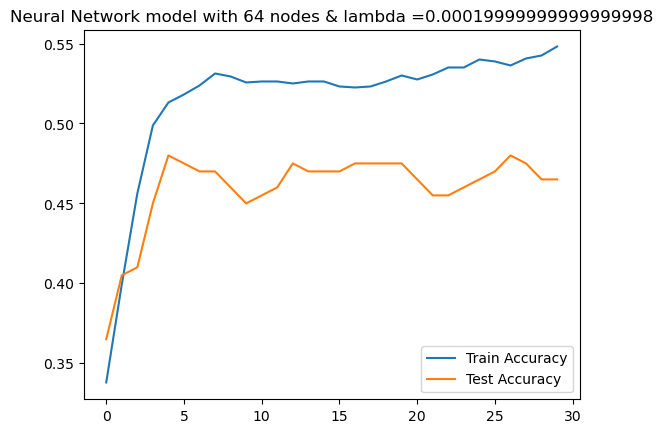

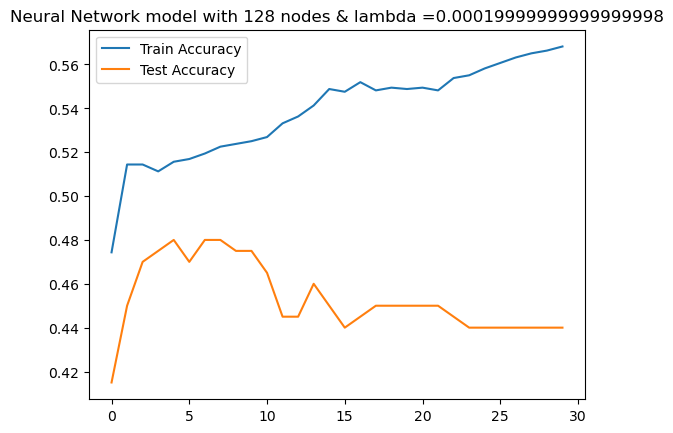

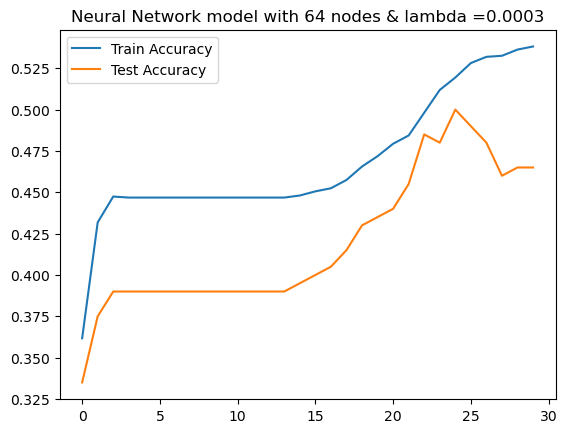

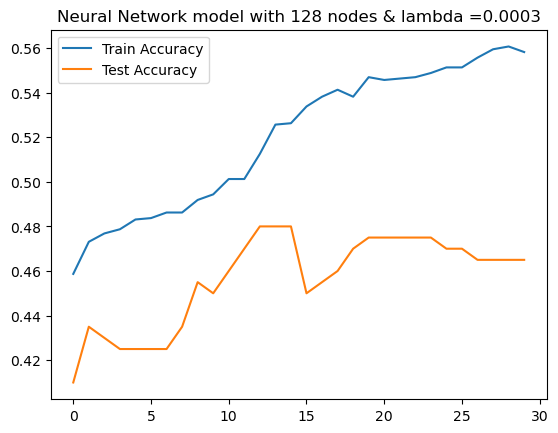

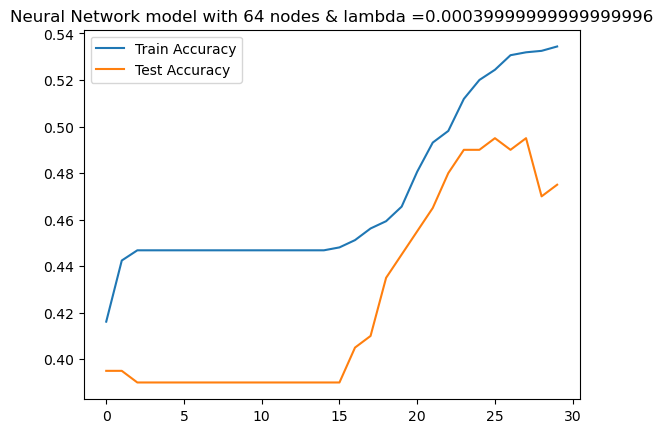

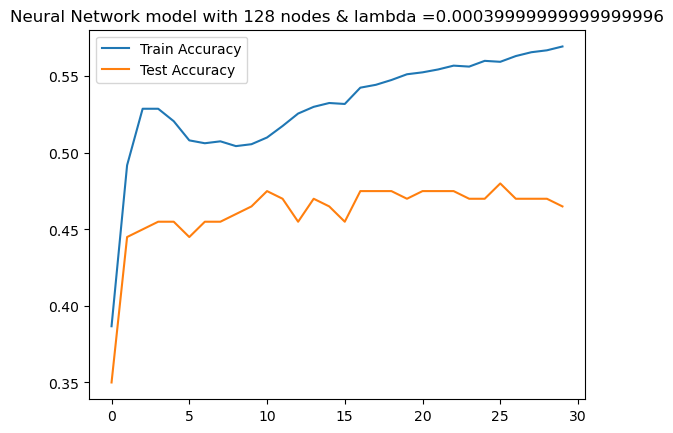

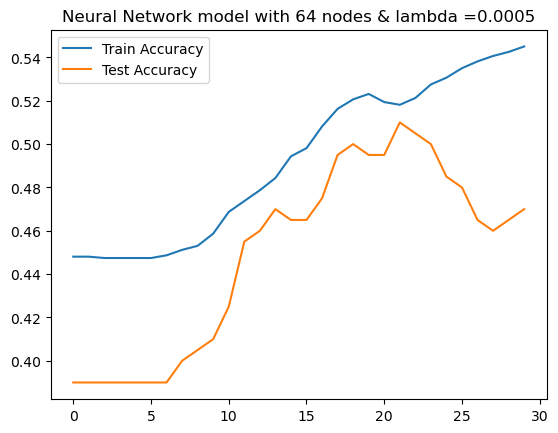

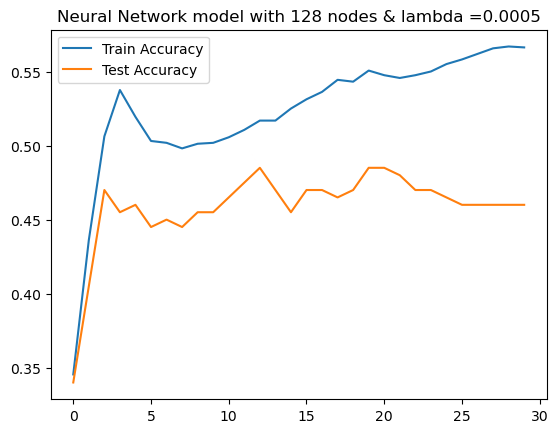

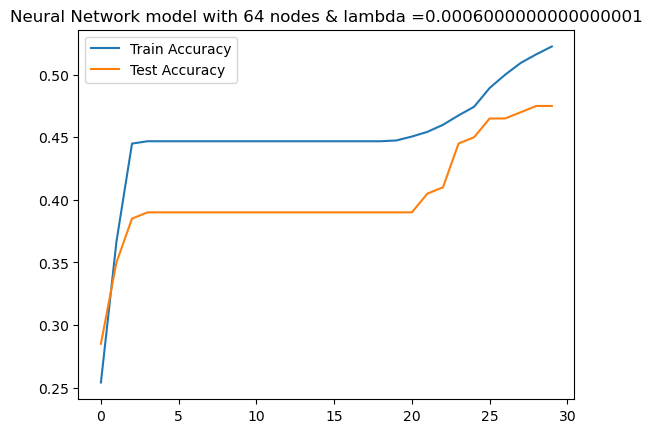

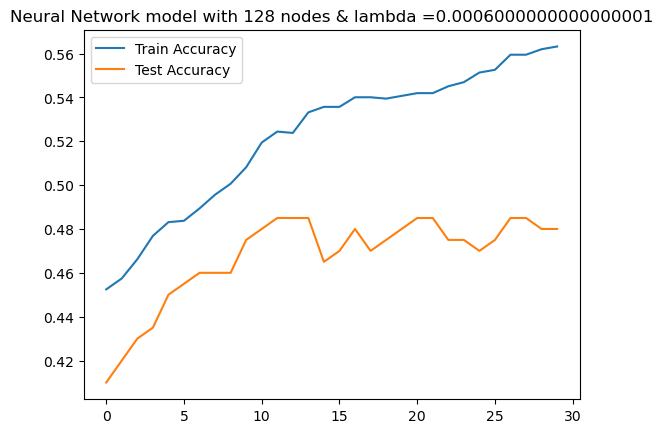

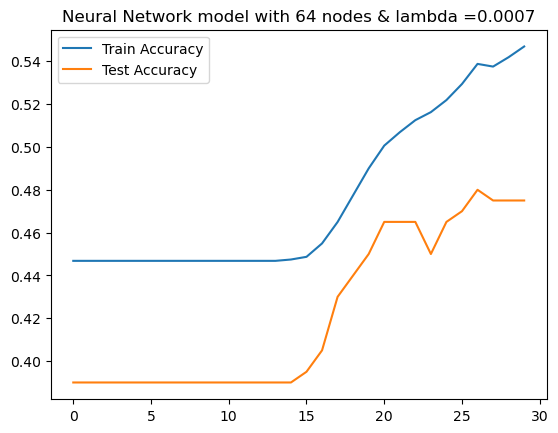

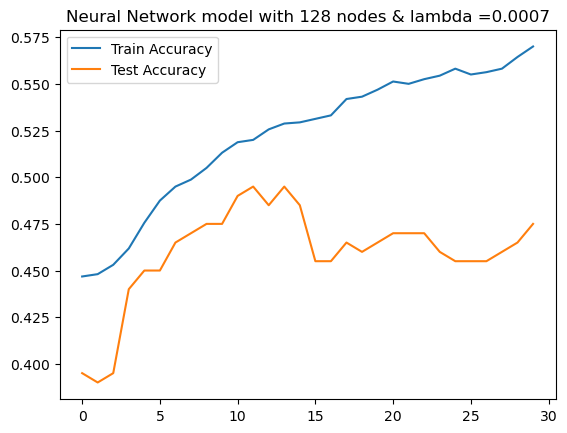

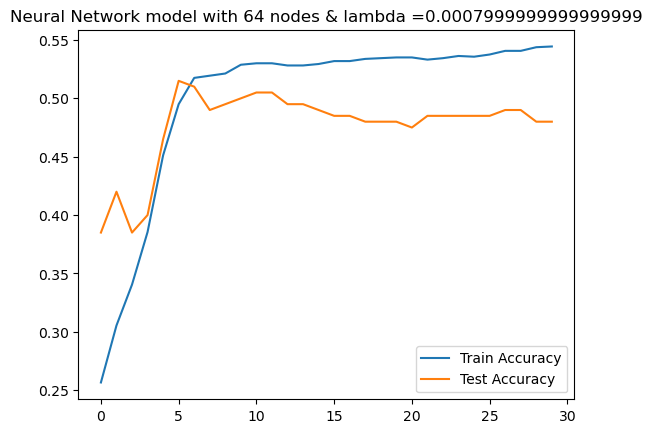

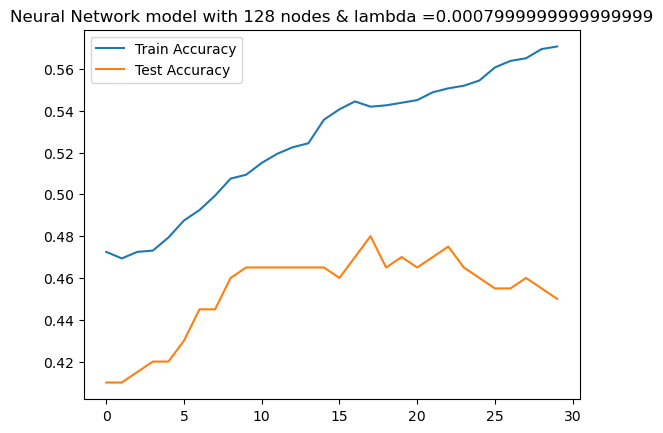

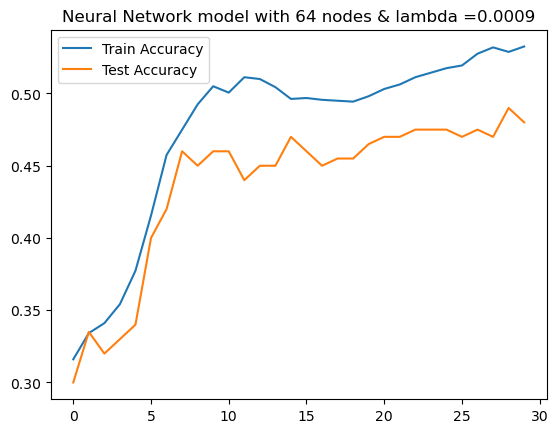

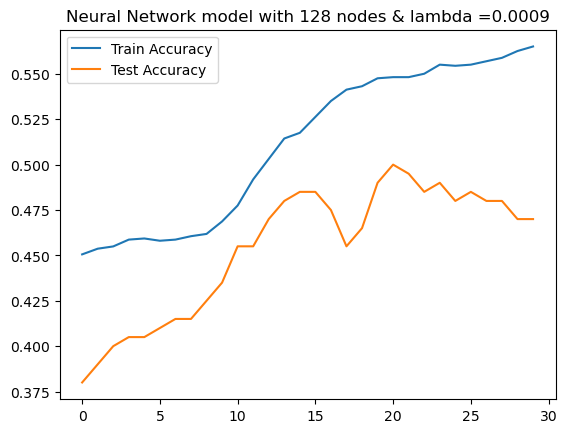

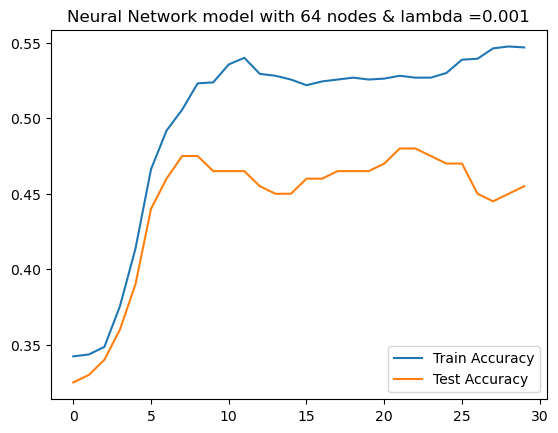

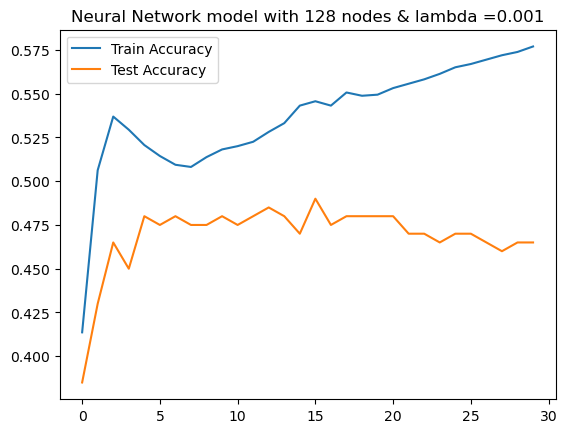

In [1368]:
def hyperparameter_tuning(X_train, X_valid, y_train, y_valid):
    input_size = X_train.shape[1]
    lambda_parameters = np.linspace(0.0001, 0.001, 10)
    nodes = 64 * np.arange(1, 3)
    models_accuracies = []

    X_train = X_train.astype(float)
    X_valid = X_valid.astype(float)

    X_train_tensor = torch.from_numpy(X_train.values).float()
    y_train_tensor = torch.from_numpy(y_train.values).float()
    X_valid_tensor = torch.from_numpy(X_valid.values).float()
    y_valid_tensor = torch.from_numpy(y_valid.values).float()

    for lambda_ in lambda_parameters:
        for node in nodes:
            model = MLP(input_size, node, 3)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters())

            highest_model_save, r_train, r_valid = [], [], []
            best_acc = 0
            for epoch in range(40):
                train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor)

                pred_labels_train = evaluate_model(model, X_train_tensor)

                pred_labels_one_hot_train = torch.zeros_like(y_train_tensor)
                pred_labels_one_hot_train.scatter_(1, pred_labels_train.unsqueeze(1), 1)

                correct_answers_train = (pred_labels_one_hot_train == y_train_tensor).all(dim=1).sum().item()
                accuracy_train = correct_answers_train / len(y_train)
                r_train.append(accuracy_train)


                pred_labels_valid = evaluate_model(model, X_valid_tensor)

                pred_labels_one_hot_valid = torch.zeros_like(y_valid_tensor)
                pred_labels_one_hot_valid.scatter_(1, pred_labels_valid.unsqueeze(1), 1)

                correct_answers_valid = (pred_labels_one_hot_valid == y_valid_tensor).all(dim=1).sum().item()
                accuracy_valid = correct_answers_valid / len(y_valid)
                r_valid.append(accuracy_valid)

                if accuracy_valid > best_acc:
                    highest_model_save.clear()
                    best_acc = accuracy_valid
                    highest_model_save.append((model, accuracy_train, accuracy_valid, node, lambda_))


            label = f'Neural Network model with {highest_model_save[0][3]} nodes & lambda ={highest_model_save[0][4]}'
            plot_accuracies(r_train, r_valid, label)

            new_tuple_info = (highest_model_save[0][:1] + (label,) + highest_model_save[0][1:])[:-2]

            # Append the model, label, and accuracy_valid to the list
            models_accuracies.append(new_tuple_info)

    return models_accuracies
# Example usage
neural_networks = hyperparameter_tuning(X_train, X_valid, y_train_one_hot, y_valid_one_hot)

In [1369]:
def objective(trial, X_train, y_train, X_valid, y_valid):

    input_size = X_train.shape[1]
    hidden_dim = trial.suggest_int('hidden_dim', 50, 256)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)

    model = MLP(input_size, hidden_dim, 3)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    X_train = X_train.astype(float)
    X_valid = X_valid.astype(float)

    X_train_tensor = torch.from_numpy(X_train.values).float()
    y_train_tensor = torch.from_numpy(y_train.values).float()
    X_valid_tensor = torch.from_numpy(X_valid.values).float()
    y_valid_tensor = torch.from_numpy(y_valid.values).float()

    # Training loop
    for _ in range(100):
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    loss_val = 100
    model.eval()
    with torch.no_grad():
        output = model(X_valid_tensor)
        val_loss = criterion(output, y_valid_tensor).item()
        pred_labels = torch.argmax(output, dim=1)

        pred_labels_one_hot_valid = torch.zeros_like(y_valid_tensor)
        pred_labels_one_hot_valid.scatter_(1, pred_labels.unsqueeze(1), 1)

        correct_answers_valid = (pred_labels_one_hot_valid == y_valid_tensor).all(dim=1).sum().item()
        accuracy_valid = correct_answers_valid / len(y_valid)

        if loss_val > val_loss:
            trial.set_user_attr("best_model", model)
            trial.set_user_attr("best_accuracy", accuracy_valid)

    if trial.should_prune():
        raise optuna.TrialPruned()

    return val_loss

<a name='results'></a>
# 6. Results

Single models results

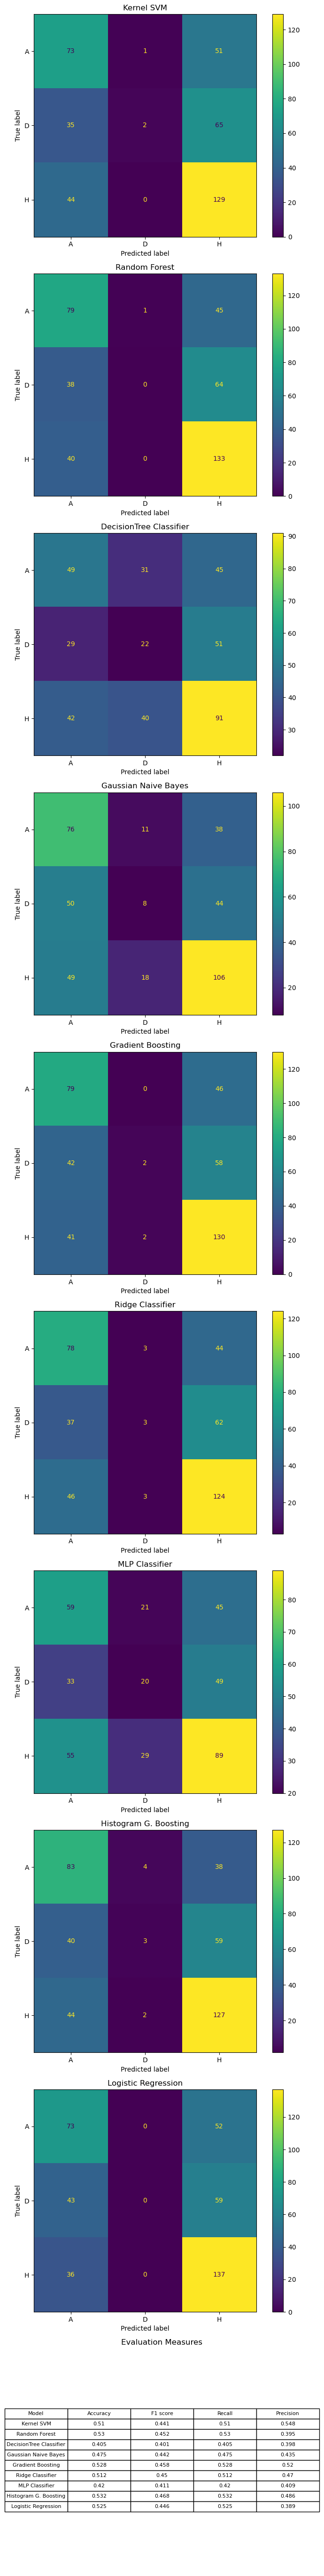

In [1466]:
fig, axes = plt.subplots(len(clf_names), 1, figsize=(7, 5 * (len(clf_names) + 1)))

eval_measures_list = []

for i, (clf_name, y_pred) in enumerate(zip(clf_names, model_preds)):
    if clf_name is not None and y_pred is not None:
        accuracy = round(accuracy_score(y_test_label, y_pred), 3)
        f1 = round(f1_score(y_test_label, y_pred, average="weighted"), 3)
        recall = round(recall_score(y_test_label, y_pred, average="weighted"), 3)
        precision = round(precision_score(y_test_label, y_pred, average="weighted"), 3)

        eval_measures_list.append([clf_name, accuracy, f1, recall, precision])  # Store evaluation measures

        ConfusionMatrixDisplay(confusion_matrix(y_test_label, y_pred),
                            display_labels=label_encoder.inverse_transform(clf.classes_)).plot(ax=axes[i])
        axes[i].set_title(clf_name)

# evaluation measures
eval_measures_df = pd.DataFrame(eval_measures_list, columns=['Model', 'Accuracy', 'F1 score', 'Recall', 'Precision'])
axes[-1].axis('off')
table = axes[-1].table(cellText=eval_measures_df.values,
               colLabels=eval_measures_df.columns,
               cellLoc='center',
               loc='center')

table.auto_set_font_size(False)
table.set_fontsize(8)  # adjust the font size as needed
axes[-1].set_title('Evaluation Measures')

plt.tight_layout()
plt.show()


Ensemble model Result

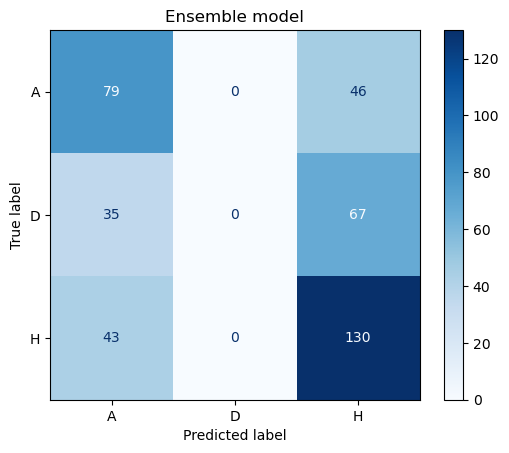

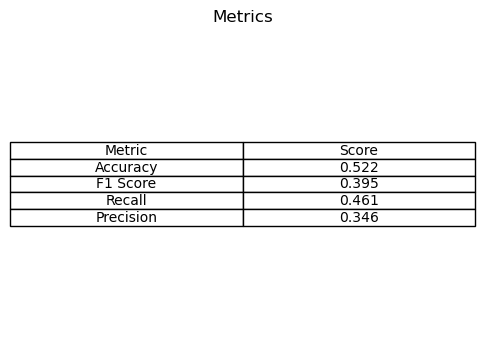

In [1371]:
# confusion matrix
cm = confusion_matrix(y_test_label, ensemble_preds)

accuracy = round(accuracy_score(y_test_label, ensemble_preds), 3)
precision = round(precision_score(y_test_label, ensemble_preds, average='weighted'), 3)
recall = round(recall_score(y_test_label, ensemble_preds, average='weighted'), 3)
f1 = round(f1_score(y_test_label, ensemble_preds, average='weighted'), 3)

# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.inverse_transform(clf.classes_))
disp.plot(cmap='Blues', values_format='d')
plt.title('Ensemble model')
plt.show()

metrics_data = {
    'Metric': ['Accuracy', 'F1 Score', 'Recall', 'Precision'],
    'Score': [accuracy, f1, recall, precision]
}

metrics_df = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(6, 4))

table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')

ax.axis('off')

plt.title('Metrics')

plt.show()

In [1372]:
# No-Information-Rate
v_count = y_test.value_counts()
count_of_most_common_label = v_count.max()
count_of_most_common_label / y_test.shape[0]

0.4325

custom mlp Results

In [1373]:
#Custom MLP Results
# model, label, accuracy_train, accuracy_valid, node, lambda_
for model, parameters, train_accuracy, test_accuracy in neural_networks:
    print(parameters, train_accuracy, test_accuracy)

Neural Network model with 64 nodes & lambda =0.0001 0.5275344180225282 0.505
Neural Network model with 128 nodes & lambda =0.0001 0.509386733416771 0.49
Neural Network model with 64 nodes & lambda =0.00019999999999999998 0.5131414267834794 0.48
Neural Network model with 128 nodes & lambda =0.00019999999999999998 0.5156445556946183 0.48
Neural Network model with 64 nodes & lambda =0.0003 0.5193992490613266 0.5
Neural Network model with 128 nodes & lambda =0.0003 0.5125156445556946 0.48
Neural Network model with 64 nodes & lambda =0.00039999999999999996 0.5244055068836045 0.495
Neural Network model with 128 nodes & lambda =0.00039999999999999996 0.5594493116395495 0.48
Neural Network model with 64 nodes & lambda =0.0005 0.5181476846057572 0.51
Neural Network model with 128 nodes & lambda =0.0005 0.5168961201501877 0.485
Neural Network model with 64 nodes & lambda =0.0006000000000000001 0.516270337922403 0.475
Neural Network model with 128 nodes & lambda =0.0006000000000000001 0.524405506

In [1374]:
def test_model(model, test_data):
    model.eval()
    with torch.no_grad():
        # Convert the DataFrame to a tensor
        test_tensor = torch.from_numpy(test_data.values.astype(np.float64)).float()
        predictions = model(test_tensor)
        pred_labels = torch.argmax(predictions, dim=1)
    return pred_labels.numpy()

In [1378]:
accuracies = [model_accuracy[3] for model_accuracy in neural_networks]
best_model_index = (accuracies.index(max(accuracies)))
best_accuracy_mlp = accuracies[best_model_index]
print(f'Best NN Model Accuracy: {best_accuracy_mlp}')
best_model_parameters = neural_networks[best_model_index][1]
print(best_model_parameters)

best_nn_model = neural_networks[best_model_index][0]

mlp_predictions = test_model(best_nn_model, X_test_mlp)
y_test_mlp_tensor = torch.from_numpy(y_test_mlp_one_hot.values).float()
mlp_predictions_tensor = torch.from_numpy(mlp_predictions)

pred_labels_one_hot_test_m1 = torch.zeros_like(y_test_mlp_tensor)
pred_labels_one_hot_test_m1.scatter_(1, mlp_predictions_tensor.unsqueeze(1), 1)

correct_answers_test_m1 = (pred_labels_one_hot_test_m1 == y_test_mlp_tensor).all(dim=1).sum().item()
accuracy_y_test_mlp = correct_answers_test_m1 / len(y_test_mlp_one_hot)
print(f'Best MLP Model test Accuracy: {accuracy_y_test_mlp}')



Best NN Model Accuracy: 0.515
Neural Network model with 64 nodes & lambda =0.0007999999999999999
Best MLP Model test Accuracy: 0.55


In [1421]:
bool_df = pd.DataFrame(pred_labels_one_hot_test_m1, dtype=bool)
bool_df

,0,1,2
0,False,False,True
1,True,False,False
2,True,False,False
3,False,False,True
4,False,False,True
...,...,...,...
195,False,False,True
196,False,False,True
197,False,False,True
198,True,False,False


In [1462]:
f1_mlp = round(f1_score(y_test_mlp_one_hot, bool_df, average="weighted"), 3)
recall_mlp = round(recall_score(y_test_mlp_one_hot, bool_df, average="weighted"), 3)
precision_mlp = round(precision_score(y_test_mlp_one_hot, bool_df, average="weighted"), 3)
print(f1_mlp)
print(recall_mlp)
print(precision_mlp)

0.48
0.55
0.427


In [1447]:
changed_df = bool_df.rename(columns={0: 'FTR_A', 1: 'FTR_D', 2: 'FTR_H'})
changed_df

,FTR_A,FTR_D,FTR_H
0,False,False,True
1,True,False,False
2,True,False,False
3,False,False,True
4,False,False,True
...,...,...,...
195,False,False,True
196,False,False,True
197,False,False,True
198,True,False,False


In [1472]:
answers_pred = changed_df.idxmax(axis=1)
print(answers_pred)

0      FTR_H
1      FTR_A
2      FTR_A
3      FTR_H
4      FTR_H
       ...  
195    FTR_H
196    FTR_H
197    FTR_H
198    FTR_A
199    FTR_H
Length: 200, dtype: object


MLP model manual Result

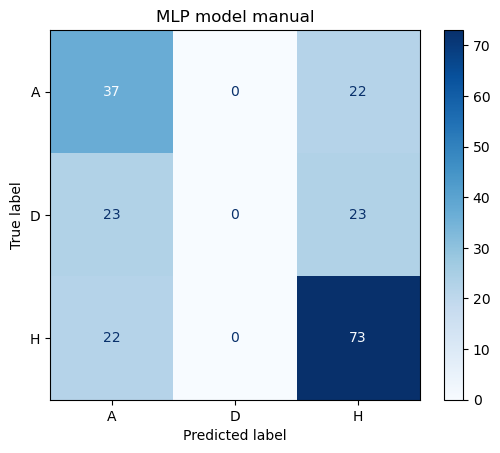

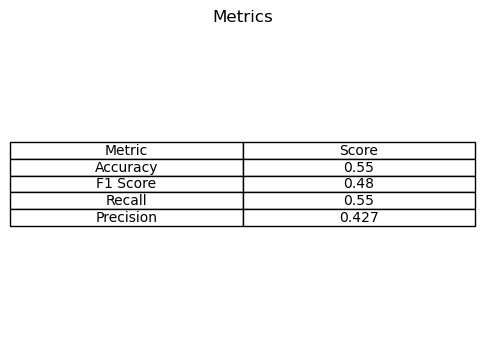

In [1478]:
answers_onehot = y_test_mlp_one_hot.idxmax(axis=1)
answers_pred = changed_df.idxmax(axis=1)

cm = confusion_matrix(answers_onehot, answers_pred)

# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'D', 'H'])
disp.plot(cmap='Blues', values_format='d')
plt.title('MLP model manual')
plt.show()

metrics_data = {
    'Metric': ['Accuracy', 'F1 Score', 'Recall', 'Precision'],
    'Score': [accuracy_y_test_mlp, f1_mlp, recall_mlp, precision_mlp]
}

metrics_df = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(6, 4))

table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')


ax.axis('off')

plt.title('Metrics')

plt.show()

In [1379]:
# Create study
study = optuna.create_study(direction='minimize')

# Optimize
#study.optimize(lambda t: objective(t, X_train, y_train_one_hot, X_valid, y_valid_one_hot), n_trials=100) # try 1000
study.optimize(lambda trial: objective(trial, X_train, y_train_one_hot, X_valid, y_valid_one_hot), n_trials=200)

[I 2023-12-18 05:34:59,040] A new study created in memory with name: no-name-be65b524-65b5-4914-be09-9ff36f6b83fd
[I 2023-12-18 05:34:59,544] Trial 0 finished with value: 1.0416992902755737 and parameters: {'hidden_dim': 111, 'lr': 0.00021928467625261435}. Best is trial 0 with value: 1.0416992902755737.
[I 2023-12-18 05:34:59,773] Trial 1 finished with value: 1.0508568286895752 and parameters: {'hidden_dim': 116, 'lr': 0.0004303682622754951}. Best is trial 0 with value: 1.0416992902755737.
[I 2023-12-18 05:34:59,953] Trial 2 finished with value: 1.0796376466751099 and parameters: {'hidden_dim': 55, 'lr': 0.0001200275725982333}. Best is trial 0 with value: 1.0416992902755737.
[I 2023-12-18 05:35:00,423] Trial 3 finished with value: 1.037419080734253 and parameters: {'hidden_dim': 201, 'lr': 0.00011939983413889569}. Best is trial 3 with value: 1.037419080734253.
[I 2023-12-18 05:35:01,007] Trial 4 finished with value: 1.0482158660888672 and parameters: {'hidden_dim': 243, 'lr': 0.0003598

In [1380]:
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_accuracy_Optuna = trial.user_attrs.get("best_accuracy")
print(f"Best Accuracy: {best_accuracy_Optuna}")

best_model_with_optuna = trial.user_attrs.get("best_model")

mlp_predictions_optuna = test_model(best_model_with_optuna, X_test_mlp)

y_test_mlp_tensor = torch.from_numpy(y_test_mlp_one_hot.values).float()
mlp_predictions_tensor_m2 = torch.from_numpy(mlp_predictions_optuna)

pred_labels_one_hot_test_m2 = torch.zeros_like(y_test_mlp_tensor)
pred_labels_one_hot_test_m2.scatter_(1, mlp_predictions_tensor_m2.unsqueeze(1), 1)

correct_answers_test_m2 = (pred_labels_one_hot_test_m2 == y_test_mlp_tensor).all(dim=1).sum().item()
accuracy_y_test_mlp2 = correct_answers_test_m2 / len(y_test_mlp_one_hot)

print(f'Best MLP Model test Accuracy: {accuracy_y_test_mlp2}')

Value:  1.0241512060165405
Params: 
    hidden_dim: 184
    lr: 0.00010094684110016726
Best Accuracy: 0.465
Best MLP Model test Accuracy: 0.555


In [1426]:
bool_df2 = pd.DataFrame(pred_labels_one_hot_test_m2, dtype=bool)
bool_df2

,0,1,2
0,False,False,True
1,True,False,False
2,True,False,False
3,False,False,True
4,False,False,True
...,...,...,...
195,False,False,True
196,False,False,True
197,True,False,False
198,True,False,False


In [1458]:
f1_mlp2 = round(f1_score(y_test_mlp_one_hot, bool_df2, average="weighted"), 3)
recall_mlp2 = round(recall_score(y_test_mlp_one_hot, bool_df2, average="weighted"), 3)
precision_mlp2 = round(precision_score(y_test_mlp_one_hot, bool_df2, average="weighted"), 3)
print(f1_mlp2)
print(recall_mlp2)
print(precision_mlp2)

0.485
0.555
0.432


In [1454]:
changed_df2 = bool_df2.rename(columns={0: 'FTR_A', 1: 'FTR_D', 2: 'FTR_H'})
changed_df2

,FTR_A,FTR_D,FTR_H
0,False,False,True
1,True,False,False
2,True,False,False
3,False,False,True
4,False,False,True
...,...,...,...
195,False,False,True
196,False,False,True
197,True,False,False
198,True,False,False


MLP model with Optuna Result

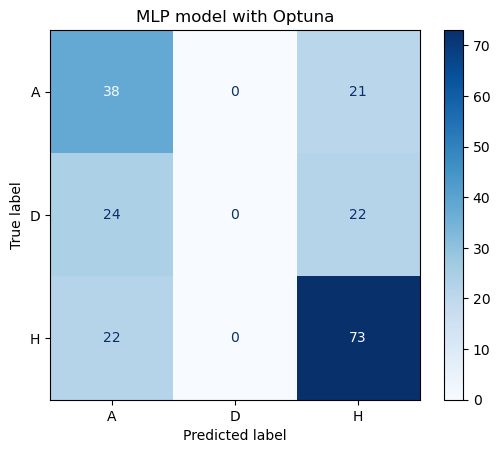

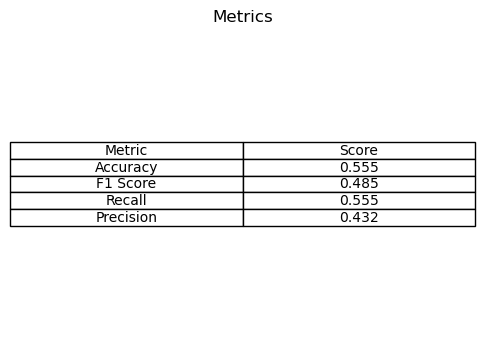

In [1479]:
answers_onehot2 = y_test_mlp_one_hot.idxmax(axis=1)
answers_pred2 = changed_df2.idxmax(axis=1)

cm = confusion_matrix(answers_onehot2, answers_pred2)

# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'D', 'H'])
disp.plot(cmap='Blues', values_format='d')
plt.title('MLP model with Optuna')
plt.show()

metrics_data = {
    'Metric': ['Accuracy', 'F1 Score', 'Recall', 'Precision'],
    'Score': [accuracy_y_test_mlp2, f1_mlp2, recall_mlp2, precision_mlp2]
}

metrics_df = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(6, 4))

table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')

ax.axis('off')

plt.title('Metrics')

plt.show()

In [1381]:
display(eval_measures_df)

,Model,Accuracy,F1 score,Recall,Precision
0,Kernel SVM,0.510,0.394,0.450,0.558
1,Random Forest,0.530,0.400,0.467,0.351
2,DecisionTree Classifier,0.405,0.377,0.378,0.377
3,Gaussian Naive Bayes,0.475,0.403,0.433,0.405
4,Gradient Boosting,0.528,0.409,0.468,0.514
5,Ridge Classifier,0.512,0.405,0.457,0.452
6,MLP Classifier,0.420,0.389,0.394,0.391
7,Histogram G. Boosting,0.532,0.421,0.476,0.466
8,Logistic Regression,0.525,0.393,0.459,0.344


<a name='final_predictions'></a>
# 7. Final Predictions on Test Set

# Prediction on Test Set

In [1382]:
test_df

,Date,HomeTeam,AwayTeam
0,2024-02-03,Bournemouth,Nott'm Forest
1,2024-02-03,Arsenal,Liverpool
2,2024-02-03,Brentford,Man City
3,2024-02-03,Brighton,Crystal Palace
4,2024-02-03,Burnley,Fulham
5,2024-02-03,Chelsea,Wolves
6,2024-02-03,Everton,Tottenham
7,2024-02-03,Man United,West Ham
8,2024-02-03,Newcastle,Luton
9,2024-02-03,Sheffield United,Aston Villa


for our test below

In [1383]:
copied_df = test_df.copy()

Make the test set have the features that the training set has

In [1384]:
def add_avg_features_in_last_five_games_for_pred(df, pred_df):
    selected_features = list(set(df.columns) - set(not_numeric_cols))

    for index, row in pred_df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        current_date = row['Date']

        # Matches that occurred before the current match
        previous_matches_team_a = df[(df['HomeTeam'] == home_team) & (df['Date'] < current_date)][selected_features]
        previous_matches_team_b = df[(df['AwayTeam'] == away_team) & (df['Date'] < current_date)][selected_features]

        # Calculate mean for available matches up to 5,
        mean_team_a = previous_matches_team_a.tail(5).mean() if len(previous_matches_team_a) >= 5 else previous_matches_team_a.mean()
        mean_team_b = previous_matches_team_b.tail(5).mean() if len(previous_matches_team_b) >= 5 else previous_matches_team_b.mean()

        # Total mean
        total_mean = pd.concat([
            mean_team_a,
            mean_team_b
        ], axis=1).mean(axis=1)

        total_mean = pd.DataFrame(total_mean).transpose()
        # name the columns
        total_mean.columns = [f'{col}_avg' for col in total_mean.columns]

        # Concatenate the total mean values to the original DataFrame
        # pred_df.loc[index, total_mean.columns] = total_mean.values.flatten()
        pred_df.loc[(pred_df['HomeTeam'] == home_team) & (pred_df['AwayTeam'] == away_team), total_mean.columns] = total_mean.values.flatten()

    return pred_df

In [1385]:
predict_df = add_avg_features_in_last_five_games_for_pred(merged_df_test, test_df)
print(predict_df)
predict_df.columns

        Date          HomeTeam        AwayTeam  pk_H_avg  HS_avg  FTAG_avg  \
0 2024-02-03       Bournemouth   Nott'm Forest       0.1    12.7       1.2   
1 2024-02-03           Arsenal       Liverpool       0.3    15.6       1.4   
2 2024-02-03         Brentford        Man City       0.1    11.3       1.7   
3 2024-02-03          Brighton  Crystal Palace       0.1    15.0       1.2   
4 2024-02-03           Burnley          Fulham       0.2    11.9       2.0   
5 2024-02-03           Chelsea          Wolves       0.2    15.1       1.2   
6 2024-02-03           Everton       Tottenham       0.1    15.5       1.7   
7 2024-02-03        Man United        West Ham       0.3    17.1       1.8   
8 2024-02-03         Newcastle           Luton       0.2    17.0       0.8   
9 2024-02-03  Sheffield United     Aston Villa       0.1    10.9       2.1   

   AS_avg  poss_H_avg  AC_avg  HST_avg  ...  FTHG_avg  pk_A_avg  HR_avg  \
0    12.3        52.4     5.1      4.3  ...       1.1       0.2   

Index(['Date', 'HomeTeam', 'AwayTeam', 'pk_H_avg', 'HS_avg', 'FTAG_avg',
       'AS_avg', 'poss_H_avg', 'AC_avg', 'HST_avg', 'AST_avg', 'HTHG_avg',
       'pkatt_H_avg', 'HF_avg', 'HC_avg', 'pkatt_A_avg', 'fk_H_avg',
       'dist_H_avg', 'poss_A_avg', 'FTHG_avg', 'pk_A_avg', 'HR_avg', 'AR_avg',
       'fk_A_avg', 'dist_A_avg', 'HY_avg', 'AY_avg', 'HTAG_avg', 'AF_avg'],
      dtype='object')

In [1386]:
predict_df.head()

,Date,HomeTeam,AwayTeam,pk_H_avg,HS_avg,FTAG_avg,AS_avg,poss_H_avg,AC_avg,HST_avg,...,FTHG_avg,pk_A_avg,HR_avg,AR_avg,fk_A_avg,dist_A_avg,HY_avg,AY_avg,HTAG_avg,AF_avg
0,2024-02-03,Bournemouth,Nott'm Forest,0.1,12.7,1.2,12.3,52.4,5.1,4.3,...,1.1,0.2,0.2,0.1,0.3,17.05,1.8,3.7,0.6,12.5
1,2024-02-03,Arsenal,Liverpool,0.3,15.6,1.4,10.1,55.8,3.8,5.7,...,2.0,0.1,0.0,0.4,0.1,18.96,1.8,3.0,0.7,11.4
2,2024-02-03,Brentford,Man City,0.1,11.3,1.7,17.6,43.2,6.8,3.7,...,1.4,0.1,0.0,0.1,0.7,17.47,2.6,2.0,0.5,10.1
3,2024-02-03,Brighton,Crystal Palace,0.1,15.0,1.2,12.7,60.6,4.0,4.8,...,1.8,0.1,0.0,0.0,0.4,16.54,2.2,2.3,0.5,12.6
4,2024-02-03,Burnley,Fulham,0.2,11.9,2.0,11.7,55.4,4.1,4.5,...,1.4,0.1,0.1,0.1,0.1,16.45,1.6,2.1,1.0,10.2


In [1387]:
def add_avg_features_in_last_two_games_face_for_pred(df, pred_df):
    selected_features = list(set(df.columns) - set(not_numeric_cols))

    for index, row in pred_df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        current_date = row['Date']

        previous_matches_team_a_and_b = df[
            (df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team) & (df['Date'] < current_date)
        ][selected_features]

        mean_team_a_and_b = previous_matches_team_a_and_b.tail(2).mean() if len(previous_matches_team_a_and_b) >= 2 else previous_matches_team_a_and_b.mean()

        mean_values = mean_team_a_and_b.squeeze()

        mean_df = pd.DataFrame(mean_values).transpose()

        mean_df.columns = [f'{col}_avg_face' for col in mean_df.columns]
        
        # Concatenate the total mean values to the original DataFrame
        #df.loc[index, mean_df.columns] = mean_df.values.flatten()
        pred_df.loc[(pred_df['HomeTeam'] == home_team) & (pred_df['AwayTeam'] == away_team), mean_df.columns] = mean_df.values.flatten()

    return pred_df

In [1388]:
predict_df = add_avg_features_in_last_two_games_face_for_pred(merged_df_test, predict_df)
print(predict_df)
predict_df.columns

        Date          HomeTeam        AwayTeam  pk_H_avg  HS_avg  FTAG_avg  \
0 2024-02-03       Bournemouth   Nott'm Forest       0.1    12.7       1.2   
1 2024-02-03           Arsenal       Liverpool       0.3    15.6       1.4   
2 2024-02-03         Brentford        Man City       0.1    11.3       1.7   
3 2024-02-03          Brighton  Crystal Palace       0.1    15.0       1.2   
4 2024-02-03           Burnley          Fulham       0.2    11.9       2.0   
5 2024-02-03           Chelsea          Wolves       0.2    15.1       1.2   
6 2024-02-03           Everton       Tottenham       0.1    15.5       1.7   
7 2024-02-03        Man United        West Ham       0.3    17.1       1.8   
8 2024-02-03         Newcastle           Luton       0.2    17.0       0.8   
9 2024-02-03  Sheffield United     Aston Villa       0.1    10.9       2.1   

   AS_avg  poss_H_avg  AC_avg  HST_avg  ...  FTHG_avg_face  pk_A_avg_face  \
0    12.3        52.4     5.1      4.3  ...            1.0      

Index(['Date', 'HomeTeam', 'AwayTeam', 'pk_H_avg', 'HS_avg', 'FTAG_avg',
       'AS_avg', 'poss_H_avg', 'AC_avg', 'HST_avg', 'AST_avg', 'HTHG_avg',
       'pkatt_H_avg', 'HF_avg', 'HC_avg', 'pkatt_A_avg', 'fk_H_avg',
       'dist_H_avg', 'poss_A_avg', 'FTHG_avg', 'pk_A_avg', 'HR_avg', 'AR_avg',
       'fk_A_avg', 'dist_A_avg', 'HY_avg', 'AY_avg', 'HTAG_avg', 'AF_avg',
       'pk_H_avg_face', 'HS_avg_face', 'FTAG_avg_face', 'AS_avg_face',
       'poss_H_avg_face', 'AC_avg_face', 'HST_avg_face', 'AST_avg_face',
       'HTHG_avg_face', 'pkatt_H_avg_face', 'HF_avg_face', 'HC_avg_face',
       'pkatt_A_avg_face', 'fk_H_avg_face', 'dist_H_avg_face',
       'poss_A_avg_face', 'FTHG_avg_face', 'pk_A_avg_face', 'HR_avg_face',
       'AR_avg_face', 'fk_A_avg_face', 'dist_A_avg_face', 'HY_avg_face',
       'AY_avg_face', 'HTAG_avg_face', 'AF_avg_face'],
      dtype='object')

check if there are any matches without previous data

In [1389]:
rows_with_nan = predict_df[predict_df.isnull().any(axis=1)]
rows_with_nan

,Date,HomeTeam,AwayTeam,pk_H_avg,HS_avg,FTAG_avg,AS_avg,poss_H_avg,AC_avg,HST_avg,...,FTHG_avg_face,pk_A_avg_face,HR_avg_face,AR_avg_face,fk_A_avg_face,dist_A_avg_face,HY_avg_face,AY_avg_face,HTAG_avg_face,AF_avg_face
8,2024-02-03,Newcastle,Luton,0.2,17.0,0.8,10.8,61.7,4.6,6.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Encoding Fourier features

In [1390]:
predict_df = generate_fourier_features_for_date(predict_df)

Index(['Date', 'HomeTeam', 'AwayTeam', 'pk_H_avg', 'HS_avg', 'FTAG_avg',
       'AS_avg', 'poss_H_avg', 'AC_avg', 'HST_avg', 'AST_avg', 'HTHG_avg',
       'pkatt_H_avg', 'HF_avg', 'HC_avg', 'pkatt_A_avg', 'fk_H_avg',
       'dist_H_avg', 'poss_A_avg', 'FTHG_avg', 'pk_A_avg', 'HR_avg', 'AR_avg',
       'fk_A_avg', 'dist_A_avg', 'HY_avg', 'AY_avg', 'HTAG_avg', 'AF_avg',
       'pk_H_avg_face', 'HS_avg_face', 'FTAG_avg_face', 'AS_avg_face',
       'poss_H_avg_face', 'AC_avg_face', 'HST_avg_face', 'AST_avg_face',
       'HTHG_avg_face', 'pkatt_H_avg_face', 'HF_avg_face', 'HC_avg_face',
       'pkatt_A_avg_face', 'fk_H_avg_face', 'dist_H_avg_face',
       'poss_A_avg_face', 'FTHG_avg_face', 'pk_A_avg_face', 'HR_avg_face',
       'AR_avg_face', 'fk_A_avg_face', 'dist_A_avg_face', 'HY_avg_face',
       'AY_avg_face', 'HTAG_avg_face', 'AF_avg_face', 'sin_time', 'cos_time'],
      dtype='object')

In [1391]:
excluded_cols = list(set(merged_df) - set(predict_df.columns))
excluded_cols

['FTR', 'HTR', 'Referee']

In [1392]:
new_merged_df = merged_df.drop(['HTR', 'FTR', 'Referee'], axis=1)

ordering before imputation

In [1394]:
new_merged_df= new_merged_df[['Date', 'HomeTeam', 'AwayTeam', 'FTAG_avg', 'AY_avg', 'HR_avg',
       'AS_avg', 'HF_avg', 'pk_H_avg', 'poss_H_avg', 'dist_H_avg',
       'pkatt_H_avg', 'AR_avg', 'FTHG_avg', 'HY_avg', 'HTHG_avg', 'pk_A_avg',
       'HS_avg', 'HST_avg', 'poss_A_avg', 'fk_H_avg', 'dist_A_avg',
       'pkatt_A_avg', 'AST_avg', 'AF_avg', 'fk_A_avg', 'HC_avg', 'HTAG_avg',
       'AC_avg', 'FTAG_avg_face', 'AY_avg_face', 'HR_avg_face', 'AS_avg_face',
       'HF_avg_face', 'pk_H_avg_face', 'poss_H_avg_face', 'dist_H_avg_face',
       'pkatt_H_avg_face', 'AR_avg_face', 'FTHG_avg_face', 'HY_avg_face',
       'HTHG_avg_face', 'pk_A_avg_face', 'HS_avg_face', 'HST_avg_face',
       'poss_A_avg_face', 'fk_H_avg_face', 'dist_A_avg_face',
       'pkatt_A_avg_face', 'AST_avg_face', 'AF_avg_face', 'fk_A_avg_face',
       'HC_avg_face', 'HTAG_avg_face', 'AC_avg_face', 'sin_time', 'cos_time']]

In [1395]:
merged_df_pred = pd.concat([new_merged_df, predict_df], axis=0)

Check if they are well combined row by row

In [1396]:
merged_df_pred.tail(12)

,Date,HomeTeam,AwayTeam,FTAG_avg,AY_avg,HR_avg,AS_avg,HF_avg,pk_H_avg,poss_H_avg,...,dist_A_avg_face,pkatt_A_avg_face,AST_avg_face,AF_avg_face,fk_A_avg_face,HC_avg_face,HTAG_avg_face,AC_avg_face,sin_time,cos_time
1996,2023-10-29,Man United,Man City,1.6,2.5,0.1,16.4,11.0,0.1,47.1,...,16.95,0.0,3.0,8.5,0.0,1.0,1.0,5.5,-0.884068,0.467359
1997,2023-10-29,West Ham,Everton,1.3,2.2,0.1,15.2,9.7,0.3,49.6,...,16.70,0.0,2.0,9.0,0.0,3.0,0.0,6.5,-0.884068,0.467359
0,2024-02-03,Bournemouth,Nott'm Forest,1.2,3.7,0.2,12.3,11.2,0.1,52.4,...,17.90,0.0,5.0,7.0,0.0,4.0,0.0,6.0,0.552435,0.833556
1,2024-02-03,Arsenal,Liverpool,1.4,3.0,0.0,10.1,9.7,0.3,55.8,...,16.20,0.0,3.0,10.0,0.0,2.5,0.5,4.5,0.552435,0.833556
2,2024-02-03,Brentford,Man City,1.7,2.0,0.0,17.6,10.3,0.1,43.2,...,18.30,0.0,3.0,9.0,0.0,3.0,0.5,4.5,0.552435,0.833556
3,2024-02-03,Brighton,Crystal Palace,1.2,2.3,0.0,12.7,11.7,0.1,60.6,...,19.75,0.0,2.0,13.5,0.5,5.0,0.0,2.0,0.552435,0.833556
4,2024-02-03,Burnley,Fulham,2.0,2.1,0.1,11.7,10.5,0.2,55.4,...,16.65,0.0,3.5,11.0,0.0,3.5,0.5,5.5,0.552435,0.833556
5,2024-02-03,Chelsea,Wolves,1.2,3.5,0.1,12.2,11.6,0.2,54.1,...,15.05,0.0,3.0,9.5,0.5,6.5,0.0,2.5,0.552435,0.833556
6,2024-02-03,Everton,Tottenham,1.7,2.2,0.0,12.8,13.6,0.1,42.7,...,19.55,0.5,1.0,15.5,0.0,3.5,0.0,2.5,0.552435,0.833556
7,2024-02-03,Man United,West Ham,1.8,2.5,0.0,12.1,9.8,0.3,59.1,...,20.10,0.0,3.0,9.0,0.0,4.0,0.0,6.5,0.552435,0.833556


Imputation for the match between Newcastle and Luton

In [1397]:
selected_features_pred = list(set(new_merged_df.columns) - set(['Date', 'HomeTeam', 'AwayTeam']))
sorted_list_pred = sorted(selected_features_pred)

imputer_mice = IterativeImputer(random_state=42)
numeric_data_pred = imputer_mice.fit_transform(merged_df_pred[sorted_list_pred])

numeric_data_df_pred = pd.DataFrame(numeric_data_pred, columns=sorted_list_pred)

Get the test set

In [1398]:
pred_df = numeric_data_df_pred.tail(10)

,AC_avg,AC_avg_face,AF_avg,AF_avg_face,AR_avg,AR_avg_face,AST_avg,AST_avg_face,AS_avg,AS_avg_face,...,pk_H_avg_face,pkatt_A_avg,pkatt_A_avg_face,pkatt_H_avg,pkatt_H_avg_face,poss_A_avg,poss_A_avg_face,poss_H_avg,poss_H_avg_face,sin_time
1998,5.1,6.000000,12.5,7.00000,0.1,0.000000,4.6,5.000000,12.3,20.000000,...,0.000000,0.2,0.00000,0.1,0.000000,47.6,57.000000,52.4,43.000000,0.552435
1999,3.8,4.500000,11.4,10.00000,0.4,0.000000,3.0,3.000000,10.1,8.500000,...,0.500000,0.1,0.00000,0.3,0.500000,44.2,54.000000,55.8,46.000000,0.552435
2000,6.8,4.500000,10.1,9.00000,0.1,0.000000,6.6,3.000000,17.6,14.500000,...,0.000000,0.2,0.00000,0.1,0.000000,56.8,70.500000,43.2,29.500000,0.552435
2001,4.0,2.000000,12.6,13.50000,0.0,0.000000,3.9,2.000000,12.7,7.000000,...,0.000000,0.1,0.00000,0.1,0.500000,39.4,40.000000,60.6,60.000000,0.552435
2002,4.1,5.500000,10.2,11.00000,0.1,0.000000,5.3,3.500000,11.7,10.000000,...,0.000000,0.1,0.00000,0.2,0.000000,44.6,55.500000,55.4,44.500000,0.552435
2003,4.5,2.500000,11.6,9.50000,0.1,0.000000,4.1,3.000000,12.2,11.000000,...,0.500000,0.0,0.00000,0.2,0.500000,45.9,42.000000,54.1,58.000000,0.552435
2004,4.6,2.500000,11.2,15.50000,0.1,0.500000,4.0,1.000000,12.8,8.000000,...,0.000000,0.0,0.50000,0.1,0.000000,57.3,58.000000,42.7,42.000000,0.552435
2005,5.0,6.500000,11.3,9.00000,0.1,0.000000,4.4,3.000000,12.1,9.500000,...,0.000000,0.1,0.00000,0.3,0.000000,40.9,45.000000,59.1,55.000000,0.552435
2006,4.6,4.501935,12.3,11.04417,0.1,0.030255,2.7,3.227363,10.8,10.785668,...,0.191855,0.0,0.05196,0.2,0.228528,38.3,48.844083,61.7,51.158832,0.552435
2007,6.8,4.500000,9.9,7.50000,0.0,0.000000,6.9,2.000000,18.0,12.000000,...,0.000000,0.1,0.50000,0.1,0.000000,54.9,58.000000,45.1,42.000000,0.552435


NAN check

In [1399]:
rows_with_nan = pred_df[pred_df.isnull().any(axis=1)]
rows_with_nan

,AC_avg,AC_avg_face,AF_avg,AF_avg_face,AR_avg,AR_avg_face,AST_avg,AST_avg_face,AS_avg,AS_avg_face,...,pk_H_avg_face,pkatt_A_avg,pkatt_A_avg_face,pkatt_H_avg,pkatt_H_avg_face,poss_A_avg,poss_A_avg_face,poss_H_avg,poss_H_avg_face,sin_time


Gaussian Scaling

In [1400]:
pred_df = pred_df.copy()
pred_df.loc[:, gaussian_features] = standardScaler.transform(pred_df.loc[:, gaussian_features])

Ordering like training set

In [ ]:
preds_df = pred_df[X_train.columns]

## Predict

results of the single models and the ensemble model with top 5 models

In [1404]:
predictions = [model.predict(preds_df) for model in models]

# extract class labels for each prediction
class_labels = [
    [label_encoder.classes_[prediction[game_index]] for prediction in predictions]
    for game_index in range(len(predictions[0]))
]

# dataFrame with the predicted class labels
predictions_df = pd.DataFrame(class_labels, columns=clf_names)

predict_data_joined = copied_df.join(predictions_df)
predict_data_joined

,Date,HomeTeam,AwayTeam,Kernel SVM,Random Forest,DecisionTree Classifier,Gaussian Naive Bayes,Gradient Boosting,Ridge Classifier,MLP Classifier,Histogram G. Boosting,Logistic Regression,Ensemble model
0,2024-02-03,Bournemouth,Nott'm Forest,H,H,D,D,H,A,A,H,H,H
1,2024-02-03,Arsenal,Liverpool,H,H,D,H,H,H,D,H,H,H
2,2024-02-03,Brentford,Man City,A,A,A,A,A,A,A,A,A,A
3,2024-02-03,Brighton,Crystal Palace,H,H,D,H,H,H,D,H,H,H
4,2024-02-03,Burnley,Fulham,A,A,H,A,A,H,A,H,H,H
5,2024-02-03,Chelsea,Wolves,H,H,H,H,H,H,H,H,H,H
6,2024-02-03,Everton,Tottenham,H,H,H,D,H,H,H,H,H,H
7,2024-02-03,Man United,West Ham,H,H,H,H,H,H,A,H,H,H
8,2024-02-03,Newcastle,Luton,H,H,H,H,H,H,H,H,H,H
9,2024-02-03,Sheffield United,Aston Villa,A,A,H,A,A,A,A,A,A,A


Results of the coustom MLPs

In [1405]:
def test_model(model, test_data):
    model.eval()
    with torch.no_grad():
        # Convert the DataFrame to a tensor
        test_tensor = torch.from_numpy(test_data.values.astype(np.float64)).float()
        predictions = model(test_tensor)
        pred_labels = torch.argmax(predictions, dim=1)
    return pred_labels.numpy()

In [1406]:
best_nn_model = neural_networks[best_model_index][0]

# get predictions
mlp_predictions = test_model(best_nn_model, preds_df)

# mapping the predicted indices to class labels 
mlp_class_labels = [label_encoder.classes_[prediction] for prediction in mlp_predictions]

mlp_predictions_df = pd.DataFrame(mlp_class_labels, columns=['MLP_Predictions'])

result_df_mlp = pd.concat([copied_df, mlp_predictions_df], axis=1)

result_df_mlp

,Date,HomeTeam,AwayTeam,MLP_Predictions
0,2024-02-03,Bournemouth,Nott'm Forest,H
1,2024-02-03,Arsenal,Liverpool,H
2,2024-02-03,Brentford,Man City,A
3,2024-02-03,Brighton,Crystal Palace,H
4,2024-02-03,Burnley,Fulham,A
5,2024-02-03,Chelsea,Wolves,H
6,2024-02-03,Everton,Tottenham,H
7,2024-02-03,Man United,West Ham,H
8,2024-02-03,Newcastle,Luton,H
9,2024-02-03,Sheffield United,Aston Villa,A


In [1409]:
# Create a new model instance with the best parameters
best_model_with_optuna = trial.user_attrs.get("best_model")

mlp_predictions_optuna = test_model(best_model_with_optuna, preds_df)

# mapping the predicted indices to class labels using label_encoder
mlp_class_labels_optuna = [label_encoder.classes_[prediction] for prediction in mlp_predictions_optuna]

mlp_predictions_optuna_df = pd.DataFrame(mlp_class_labels, columns=['MLP_Optuna'])

result_df_mlp_optuna = pd.concat([copied_df, mlp_predictions_optuna_df], axis=1)

result_df_mlp_optuna

,Date,HomeTeam,AwayTeam,MLP_Optuna
0,2024-02-03,Bournemouth,Nott'm Forest,H
1,2024-02-03,Arsenal,Liverpool,H
2,2024-02-03,Brentford,Man City,A
3,2024-02-03,Brighton,Crystal Palace,H
4,2024-02-03,Burnley,Fulham,A
5,2024-02-03,Chelsea,Wolves,H
6,2024-02-03,Everton,Tottenham,H
7,2024-02-03,Man United,West Ham,H
8,2024-02-03,Newcastle,Luton,H
9,2024-02-03,Sheffield United,Aston Villa,A


Results of the best model

In [1413]:
team_mapping = {
    'Bournemouth': 'AFC Bournemouth',
    'Man United': 'Man Utd',
    'Sheffield United': 'Sheff Utd',
    "Nott'm Forest": "Nottingham Forest",
    'Tottenham': 'Spurs',
    'Luton': 'Luton Town'
}

def get_highest_accuracy_model(models, neural_networks, X_test, y_valid):
    accuracies = [model.score(X_test, y_valid) for model in models] + [accuracy_y_test_mlp, accuracy_y_test_mlp2]
    max_accuracy_index = accuracies.index(max(accuracies))
    return max_accuracy_index

def show_predictions(max_accuracy_index, clf_names):
    display_df = (
        predict_data_joined.iloc[:, [0, 1, 2, max_accuracy_index + 3]]
        if max_accuracy_index < len(clf_names)
        else result_df_mlp_optuna if accuracy_y_test_mlp2 >= accuracy_y_test_mlp else result_df_mlp
    )
    display(display_df)
    display_df['HomeTeam'].replace(team_mapping, inplace=True)
    display_df['AwayTeam'].replace(team_mapping, inplace=True)
    display_df['Date'].dt.strftime('%d-%b-%y')
    display_df.rename(columns={'MLP_Optuna': 'FTR'}, inplace=True)
    display_df.to_csv(dataset_path + 'final_submission.csv', index=False, date_format='%d-%b-%y')

max_accuracy_index = get_highest_accuracy_model(models, neural_networks, X_test, y_test_label)
show_predictions(max_accuracy_index, clf_names)

,Date,HomeTeam,AwayTeam,MLP_Optuna
0,2024-02-03,Bournemouth,Nott'm Forest,H
1,2024-02-03,Arsenal,Liverpool,H
2,2024-02-03,Brentford,Man City,A
3,2024-02-03,Brighton,Crystal Palace,H
4,2024-02-03,Burnley,Fulham,A
5,2024-02-03,Chelsea,Wolves,H
6,2024-02-03,Everton,Tottenham,H
7,2024-02-03,Man United,West Ham,H
8,2024-02-03,Newcastle,Luton,H
9,2024-02-03,Sheffield United,Aston Villa,A


<a name='references'></a>
# 8. References

[1]"Research and analysis AI activity in UK businesses: Executive Summary," GOV.UK, 2022. [Online]. Available: https://www.gov.uk/government/publications/ai-activity-in-uk-businesses/ai-activity-in-uk-businesses-executive-summary/. [Accessed: Day- Month- Year].

[2]DATAVERSITY, "A Brief History of Machine Learning," 2023. [Online]. Available: https://www.dataversity.net/a-brief-history-of-machine-learning/.

